In [154]:
import os
import math
import datetime
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import scipy

## Setup

In [2]:
driver_ids = []
with open('driver_ids.csv', 'r') as f:
    driver_ids_raw = f.readlines()[1:]
    for row in driver_ids_raw:
        parsed_row = row[:-1].split(',')
        parsed_row[1] = datetime.datetime.strptime(parsed_row[1], '%Y-%m-%d %H:%M:%S')
        driver_ids.append(parsed_row)
    
print("Number of drivers:", len(driver_ids))

driver_ids_map = {}
for driver_id, onboard_date in driver_ids:
    driver_ids_map[driver_id] = onboard_date

Number of drivers: 937


In [3]:
ride_ids = []
with open('ride_ids.csv', 'r') as f:
    ride_ids_raw = f.readlines()[1:]
    for row in ride_ids_raw:
        parsed_row = row[:-1].split(',')
        for i in range(2,5):
            parsed_row[i] = int(parsed_row[i]) 
        ride_ids.append(parsed_row)

print("Number of rides:", len(ride_ids))

ride_ids_map = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    ride_ids_map[ride_id] = [ride_distance, ride_duration, ride_prime_time]
    
driver_to_ride = {}
ride_to_driver = {}
for driver_id, ride_id, ride_distance, ride_duration, ride_prime_time in ride_ids:
    driver_to_ride.setdefault(driver_id, []).append(ride_id)
    ride_to_driver[driver_id] = ride_id

Number of rides: 193502


In [4]:
ride_timestamps = []
with open('ride_timestamps.csv', 'r') as f:
    ride_timestamps_raw = f.readlines()[1:]
    for row in ride_timestamps_raw:
        parsed_row = row[:-1].split(',')
        try:
            parsed_row[2] = datetime.datetime.strptime(parsed_row[2], '%Y-%m-%d %H:%M:%S')
        except:
            print(row)
            # TODO: 72f0fa0bd86800e9da5c4dced32c8735 has a missing timestamp with arrived at.
            # It is currently hard coded in using the picked up at time. This needs to be checked.
            parsed_row[2] = datetime.datetime.strptime("2016-04-20 12:02:20", '%Y-%m-%d %H:%M:%S')
        ride_timestamps.append(parsed_row)
    
print("Number of rides:", len(ride_timestamps))

ride_timestamps_map = {}
for ride_id, event, timestamp in ride_timestamps:
    #ride_timestamps_map[ride_id] = [event, timestamp]
    ride_timestamps_map.setdefault(ride_id, {})[event] = timestamp

72f0fa0bd86800e9da5c4dced32c8735,arrived_at,

Number of rides: 970405


In [5]:
data_structures = '''
List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']
'''
print(data_structures)


List of Data Structures

driver_ids: 937 rows of ['driver_id', driver_onboard_date (datetime)]
driver_ids_map: 'driver_id' -> driver_onboard_date (datetime)

ride_ids: 193502 rows of ['driver_id', 'ride_id', ride_distance (int, m), ride_duration (int, s), ride_prime_time (int)]
ride_ids_map: 'ride_id' -> [ride_distance (int, m), ride_duration (int, s), ride_prime_time]
driver_to_ride: 'driver_id' -> list of ride_ids
ride_to_driver: 'ride_id' -> 'driver_id'

ride_timestamps: 970405 rows of ['ride_id', 'event', timestamp (datetime)]
ride_timestamps_map: 'ride_id' -> ('event' -> timestamp (datetime))

list of prime times: [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
list of events: ['requested_at', 'dropped_off_at', 'accepted_at', 'picked_up_at', 'arrived_at']



## Average Projected Driver Lifetime

Number of days


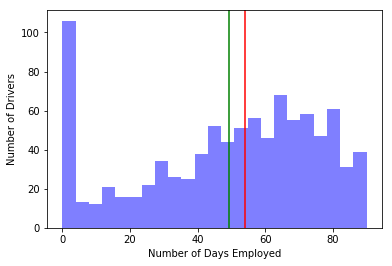

Lifetime Days Mean: 49.200640341515474 Lifetime Days Median: 54.0


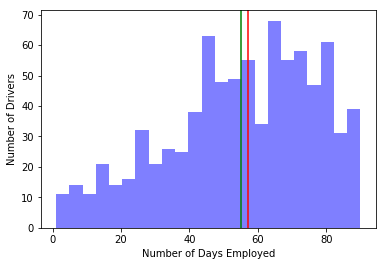

Lifetime Days Mean Clean: 55.07885304659498 Lifetime Days Median Clean: 57.0


In [194]:
print("Number of days")

driver_days = {}
for driver_id, onboard_date in driver_ids:
    max_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            max_time = max(max_time, (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days)
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_days[driver_id] = max_time

lifetime_days = list(driver_days.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 23
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.xlabel('Number of Days Employed')
plt.ylabel('Number of Drivers')
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)

lifetime_days_clean = [x for x in lifetime_days if x != 0]
lifetime_days_mean_clean = np.mean(np.asarray(lifetime_days_clean))
lifetime_days_median_clean = np.median(np.asarray(lifetime_days_clean))
n, bins, patches = plt.hist(lifetime_days_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean_clean, color='green')
plt.axvline(x=lifetime_days_median_clean, color='red')
plt.xlabel('Number of Days Employed')
plt.ylabel('Number of Drivers')
plt.show()
print("Lifetime Days Mean Clean:", lifetime_days_mean_clean, "Lifetime Days Median Clean:", lifetime_days_median_clean)

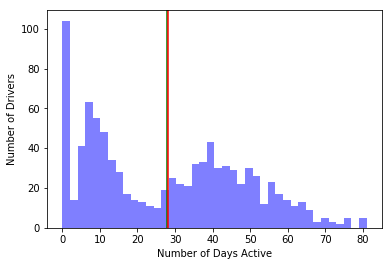

Active Lifetime Days Mean: 27.87086446104589 Active Lifetime Days Median: 28.0


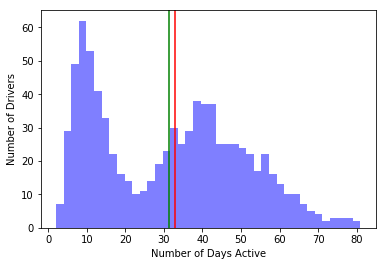

Active Lifetime Days Mean Clean: 31.200716845878137 Active Lifetime Days Median Clean: 33.0


In [198]:
driver_days_active = {}
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            active_temp.add(ride_day)
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_days_active[driver_id] = len(active_temp)
#print(driver_lifetime_active)

active_lifetime_days = list(driver_days_active.values())
active_lifetime_days_mean = np.mean(np.asarray(active_lifetime_days))
active_lifetime_days_median = np.median(np.asarray(active_lifetime_days))

num_bins = 40
n, bins, patches = plt.hist(active_lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=active_lifetime_days_mean, color='green')
plt.axvline(x=active_lifetime_days_median, color='red')
plt.xlabel('Number of Days Active')
plt.ylabel('Number of Drivers')
plt.show()
print("Active Lifetime Days Mean:", active_lifetime_days_mean, "Active Lifetime Days Median:", active_lifetime_days_median)

active_lifetime_days_clean = [x for x in active_lifetime_days if x != 0]
active_lifetime_days_mean_clean = np.mean(np.asarray(active_lifetime_days_clean))
active_lifetime_days_median_clean = np.median(np.asarray(active_lifetime_days_clean))
n, bins, patches = plt.hist(active_lifetime_days_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=active_lifetime_days_mean_clean, color='green')
plt.axvline(x=active_lifetime_days_median_clean, color='red')
plt.xlabel('Number of Days Active')
plt.ylabel('Number of Drivers')
plt.show()
print("Active Lifetime Days Mean Clean:", active_lifetime_days_mean_clean, "Active Lifetime Days Median Clean:", active_lifetime_days_median_clean)

Number of rides


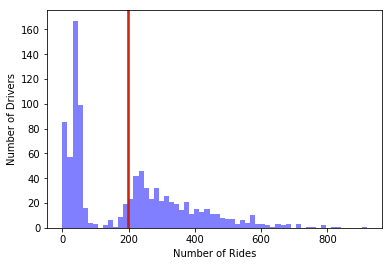

Lifetime Rides Mean: 198.3895410885806 Lifetime Rides Median: 200.0


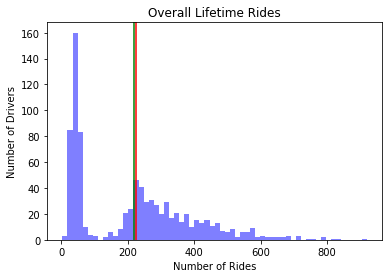

Lifetime Rides Clean Mean: 217.67096018735364 Lifetime Rides Clean Median: 223.0
Short drivers 345


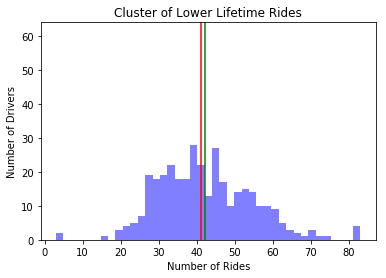

Lifetime Rides Short Mean: 42.176811594202896 Lifetime Rides Short Median: 41.0
Long drivers: 509


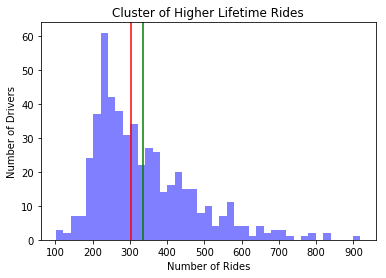

Lifetime Rides Long Mean: 336.6208251473477 Lifetime Rides Long Median: 302.0


In [178]:
print("Number of rides")
lifetime_rides = []
for driver_id, onboard_date in driver_ids:
    lifetime_rides.append(len(driver_to_ride.get(driver_id,[])))
lifetime_rides_mean = np.mean(np.asarray(lifetime_rides))
lifetime_rides_median = np.median(np.asarray(lifetime_rides))

num_bins = 60
n, bins, patches = plt.hist(lifetime_rides, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_mean, color='green')
plt.axvline(x=lifetime_rides_median, color='red')
plt.xlabel('Number of Rides')
plt.ylabel('Number of Drivers')
plt.show()
print("Lifetime Rides Mean:", lifetime_rides_mean, "Lifetime Rides Median:", lifetime_rides_median)

lifetime_rides_clean = [x for x in lifetime_rides if x != 0]
lifetime_rides_clean_mean = np.mean(np.asarray(lifetime_rides_clean))
lifetime_rides_clean_median = np.median(np.asarray(lifetime_rides_clean))
n, bins, patches = plt.hist(lifetime_rides_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_clean_mean, color='green')
plt.axvline(x=lifetime_rides_clean_median, color='red')
plt.xlabel('Number of Rides')
plt.ylabel('Number of Drivers')
plt.title('Overall Lifetime Rides')
plt.show()
print("Lifetime Rides Clean Mean:", lifetime_rides_clean_mean, "Lifetime Rides Clean Median:", lifetime_rides_clean_median)

num_bins = 41
lifetime_rides_short = [x for x in lifetime_rides_clean if x < 100]
print("Short drivers", len(lifetime_rides_short))
lifetime_rides_short_mean = np.mean(np.asarray(lifetime_rides_short))
lifetime_rides_short_median = np.median(np.asarray(lifetime_rides_short))
n, bins, patches = plt.hist(lifetime_rides_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_short_mean, color='green')
plt.axvline(x=lifetime_rides_short_median, color='red')
plt.ylim(top=64.05)
plt.xlabel('Number of Rides')
plt.ylabel('Number of Drivers')
plt.title('Cluster of Lower Lifetime Rides')
plt.show()
print("Lifetime Rides Short Mean:", lifetime_rides_short_mean, "Lifetime Rides Short Median:", lifetime_rides_short_median)

lifetime_rides_long = [x for x in lifetime_rides_clean if x >= 100]
print("Long drivers:", len(lifetime_rides_long))
lifetime_rides_long_mean = np.mean(np.asarray(lifetime_rides_long))
lifetime_rides_long_median = np.median(np.asarray(lifetime_rides_long))
n, bins, patches = plt.hist(lifetime_rides_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_rides_long_mean, color='green')
plt.axvline(x=lifetime_rides_long_median, color='red')
plt.xlabel('Number of Rides')
plt.ylabel('Number of Drivers')
plt.title('Cluster of Higher Lifetime Rides')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_rides_long_mean, "Lifetime Rides Long Median:", lifetime_rides_long_median)

### Adjusted Lifetime Rides

In [118]:
#Absolute start date
first_onboard_date = None
counter = 0
for driver_id, onboard_date in driver_ids:
    if(counter == 0):
        first_onboard_date = onboard_date
    else:
        if((first_onboard_date - onboard_date).days > 0):
            first_onboard_date = onboard_date
    counter += 1

driver_start_since_first = {}        
driver_days_since_first = {}
valid_driver_ids = set()
for driver_id, onboard_date in driver_ids:
    max_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            max_time = max(max_time, (ride_timestamps_map[ride_id]['arrived_at'] - first_onboard_date).days)
            driver_start_since_first[driver_id] = (onboard_date-first_onboard_date).days
            valid_driver_ids.add(driver_id)
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_days_since_first[driver_id] = max_time

week_onboarding_groups = [[] for i in range(0, 14)]
for driver_id in valid_driver_ids:
    week_onboarding_groups[int(driver_start_since_first[driver_id]/7)].append(driver_days_since_first[driver_id])

size_week_onboarding_groups = [len(week_onboarding_groups[i]) for i in range(0,13)]    
print(size_week_onboarding_groups, "Total:", sum(size_week_onboarding_groups))

drop_offs = [[0 for i in range(0, 14)] for j in range(0,7)]
for group in range(0, 7):
    for week in range(group, 14):
        for i in week_onboarding_groups[group]:
            #print(i, (week+1)*7)
            if(i < (week+1)*7):
                drop_offs[group][week] += 1
        if(week != 0 and week != group):
            drop_offs[group][week] -= drop_offs[group][week-1]
print(drop_offs)

[128, 148, 127, 123, 111, 104, 96, 0, 0, 0, 0, 0, 0] Total: 837
[[4, 5, 8, 10, 15, 16, 18, 20, 19, 23, 26, 35, 93, 35], [0, 2, 3, 5, 8, 12, 10, 14, 14, 19, 28, 30, 117, 31], [0, 0, 0, 4, 1, 9, 5, 14, 11, 18, 16, 26, 101, 26], [0, 0, 0, 1, 1, 4, 8, 10, 10, 21, 13, 34, 89, 34], [0, 0, 0, 0, 2, 3, 11, 5, 16, 16, 24, 23, 88, 23], [0, 0, 0, 0, 0, 0, 2, 6, 5, 18, 12, 26, 77, 27], [0, 0, 0, 0, 0, 0, 0, 4, 5, 8, 15, 14, 82, 14]]


Number of rides
Week 0


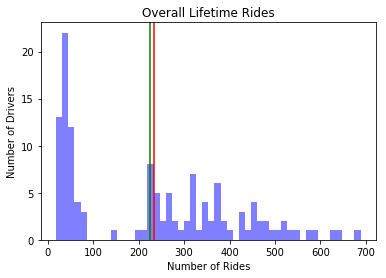

Lifetime Rides Clean Mean: 226.0390625 Lifetime Rides Clean Median: 233.0
Week 1


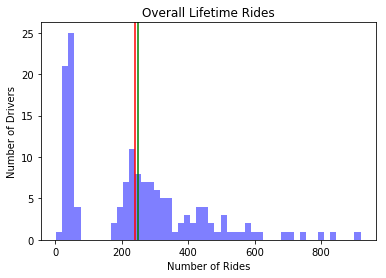

Lifetime Rides Clean Mean: 248.0472972972973 Lifetime Rides Clean Median: 240.5
Week 2


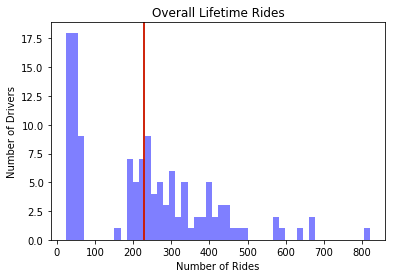

Lifetime Rides Clean Mean: 227.5275590551181 Lifetime Rides Clean Median: 230.0
Week 3


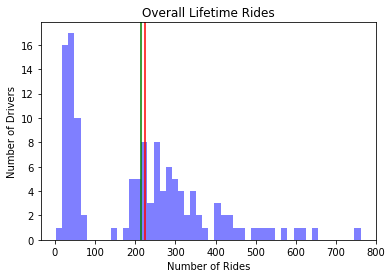

Lifetime Rides Clean Mean: 215.2520325203252 Lifetime Rides Clean Median: 224.0
Week 4


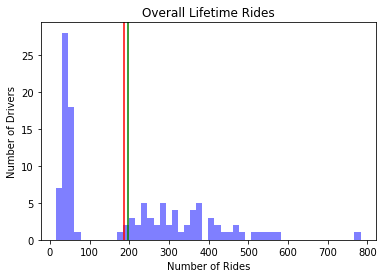

Lifetime Rides Clean Mean: 197.61261261261262 Lifetime Rides Clean Median: 188.0
Week 5


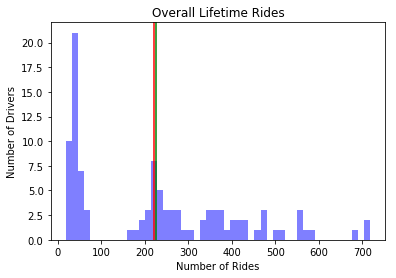

Lifetime Rides Clean Mean: 226.94230769230768 Lifetime Rides Clean Median: 221.5
Week 6


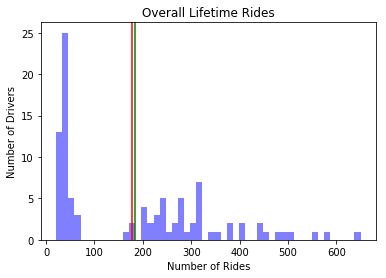

Lifetime Rides Clean Mean: 183.91666666666666 Lifetime Rides Clean Median: 178.5


In [110]:
print("Number of rides")
lifetime_ride_weeks = [[] for x in range(7)]
for driver_id, onboard_date in driver_ids:
    try:
        lifetime_ride_weeks[int(driver_start_since_first[driver_id]/7)].append(len(driver_to_ride.get(driver_id,[])))
    except:
        pass
    
total = 0
for i in range(7):
    lifetime_rides = lifetime_ride_weeks[i]

    print("Week",i)

    lifetime_rides_clean = [x for x in lifetime_rides if x != 0]
    lifetime_rides_clean_mean = np.mean(np.asarray(lifetime_rides_clean))
    lifetime_rides_clean_median = np.median(np.asarray(lifetime_rides_clean))
    n, bins, patches = plt.hist(lifetime_rides_clean, num_bins, facecolor='blue', alpha=0.5)
    plt.axvline(x=lifetime_rides_clean_mean, color='green')
    plt.axvline(x=lifetime_rides_clean_median, color='red')
    plt.xlabel('Number of Rides')
    plt.ylabel('Number of Drivers')
    plt.title('Overall Lifetime Rides')
    plt.show()
    print("Lifetime Rides Clean Mean:", lifetime_rides_clean_mean, "Lifetime Rides Clean Median:", lifetime_rides_clean_median)

Number of days
Week 0


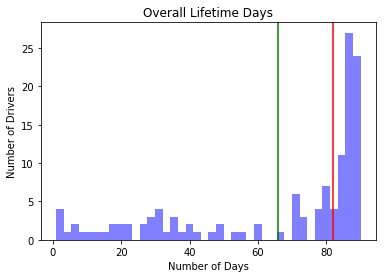

Lifetime Rides Clean Mean: 65.828125 Lifetime Rides Clean Median: 82.0
Week 1


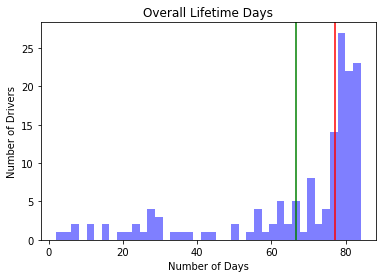

Lifetime Rides Clean Mean: 66.52027027027027 Lifetime Rides Clean Median: 77.0
Week 2


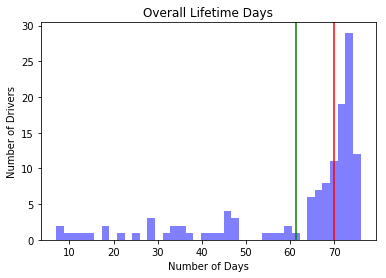

Lifetime Rides Clean Mean: 61.46456692913386 Lifetime Rides Clean Median: 70.0
Week 3


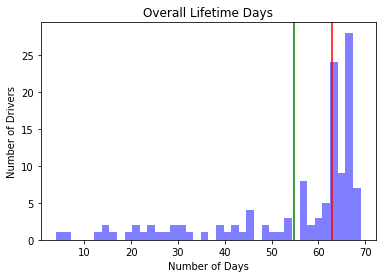

Lifetime Rides Clean Mean: 54.8130081300813 Lifetime Rides Clean Median: 63.0
Week 4


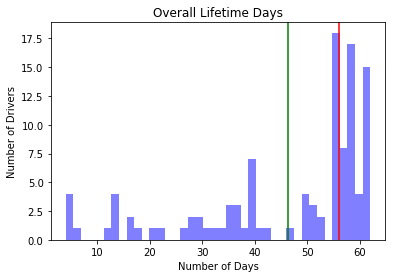

Lifetime Rides Clean Mean: 46.387387387387385 Lifetime Rides Clean Median: 56.0
Week 5


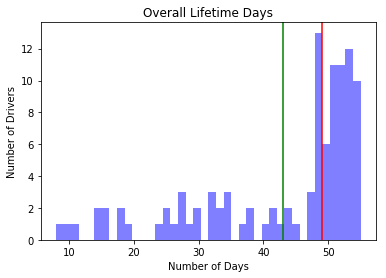

Lifetime Rides Clean Mean: 43.07692307692308 Lifetime Rides Clean Median: 49.0
Week 6


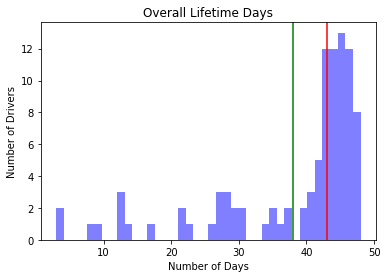

Lifetime Rides Clean Mean: 38.052083333333336 Lifetime Rides Clean Median: 43.0


In [163]:
print("Number of days")
lifetime_days_weeks = [[] for x in range(7)]
for driver_id, onboard_date in driver_ids:
    max_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            max_time = max(max_time, (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days)
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    try:
        lifetime_days_weeks[int(driver_start_since_first[driver_id]/7)].append(max_time)
    except:
        pass
    
for i in range(7):
    lifetime_rides = lifetime_days_weeks[i]

    print("Week",i)

    lifetime_rides_clean = [x for x in lifetime_rides if x != 0]
    lifetime_rides_clean_mean = np.mean(np.asarray(lifetime_rides_clean))
    lifetime_rides_clean_median = np.median(np.asarray(lifetime_rides_clean))
    n, bins, patches = plt.hist(lifetime_rides_clean, num_bins, facecolor='blue', alpha=0.5)
    plt.axvline(x=lifetime_rides_clean_mean, color='green')
    plt.axvline(x=lifetime_rides_clean_median, color='red')
    plt.xlabel('Number of Days')
    plt.ylabel('Number of Drivers')
    plt.title('Overall Lifetime Days')
    plt.show()
    print("Lifetime Rides Clean Mean:", lifetime_rides_clean_mean, "Lifetime Rides Clean Median:", lifetime_rides_clean_median)

In [177]:
last_ride_date = None
last_start_date = None
counter = 0
for driver_id, onboard_date in driver_ids:
    if last_start_date is None:
        last_start_date = onboard_date
    else:
        if (last_start_date - onboard_date).days < 0:
            last_start_date = onboard_date
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            onboard_date = ride_timestamps_map[ride_id]['arrived_at']
            if(counter == 0 and onboard_date):
                last_ride_date = onboard_date
                counter += 1
            else:
                if((last_ride_date - onboard_date).days < 0):
                    last_ride_date = onboard_date
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
print("First onboard", first_onboard_date, "Last ride", last_ride_date, "Last onboard", last_start_date)

First onboard 2016-03-28 00:00:00 Last ride 2016-06-27 00:02:03 Last onboard 2016-05-15 00:00:00


Number of days
Drivers that stopped driving: 308


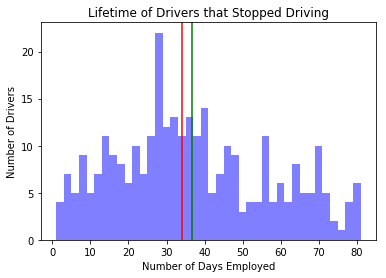

Lifetime Days Mean: 36.58116883116883 Lifetime Days Median: 34.0


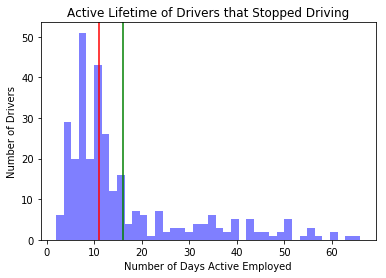

Lifetime Days Mean: 16.12987012987013 Lifetime Days Median: 11.0
First bump: 234


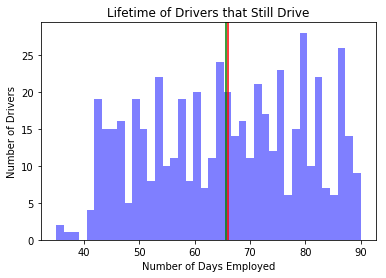

Lifetime Days Mean: 65.6086956521739 Lifetime Days Median: 66.0


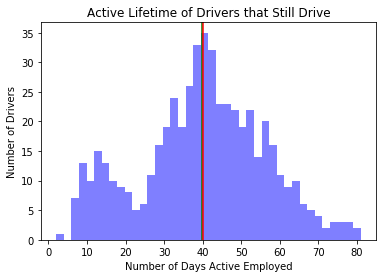

Lifetime Days Mean: 39.975425330812854 Lifetime Days Median: 40.0
First bump: 78


In [184]:
print("Number of days")

driver_days = {}
driver_days_alive = {}
driver_active_days = {}
driver_active_days_alive = {}
for driver_id, onboard_date in driver_ids:
    last_date = None
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            cur_ride = ride_timestamps_map[ride_id]['arrived_at']
            if last_date == None:
                last_date = cur_ride
            else:
                if (cur_ride - last_date).days > 0:
                    last_date = cur_ride
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if last_date is not None and (last_ride_date - last_date).days > 7:
        driver_days[driver_id] = (last_date - onboard_date).days
        driver_active_days[driver_id] = driver_days_active[driver_id]
    elif last_date is not None:
        driver_days_alive[driver_id] = (last_date - onboard_date).days
        driver_active_days_alive[driver_id] = driver_days_active[driver_id]
        
print("Drivers that stopped driving:", len(driver_days))

lifetime_days = list(driver_days.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 40
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.xlabel('Number of Days Employed')
plt.ylabel('Number of Drivers')
plt.title("Lifetime of Drivers that Stopped Driving")
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)

lifetime_days = list(driver_active_days.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 40
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.xlabel('Number of Days Active Employed')
plt.ylabel('Number of Drivers')
plt.title("Active Lifetime of Drivers that Stopped Driving")
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)
print("First bump:", len([x for x in lifetime_days if x < 20]))

lifetime_days = list(driver_days_alive.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 40
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.xlabel('Number of Days Employed')
plt.ylabel('Number of Drivers')
plt.title("Lifetime of Drivers that Still Drive")
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)

lifetime_days = list(driver_active_days_alive.values())
lifetime_days_mean = np.mean(np.asarray(lifetime_days))
lifetime_days_median = np.median(np.asarray(lifetime_days))

num_bins = 40
n, bins, patches = plt.hist(lifetime_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_days_mean, color='green')
plt.axvline(x=lifetime_days_median, color='red')
plt.xlabel('Number of Days Active Employed')
plt.ylabel('Number of Drivers')
plt.title("Active Lifetime of Drivers that Still Drive")
plt.show()
print("Lifetime Days Mean:", lifetime_days_mean, "Lifetime Days Median:", lifetime_days_median)
print("First bump:", len([x for x in lifetime_days if x < 20]))


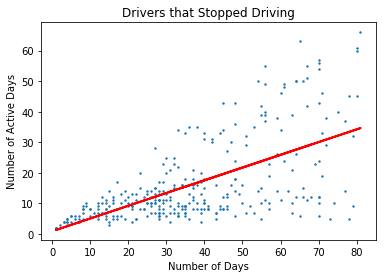

r squared: 0.38


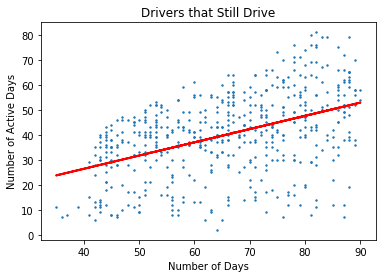

r squared: 0.21


In [172]:
x = []
y = []
for driver_id, days in driver_days.items():
    x.append(days)
    y.append(driver_days_active[driver_id])
x_r = np.asarray(x).reshape(-1, 1)
y_r = np.asarray(y).reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(x_r, y_r)
y_pred = regr.predict(x_r)

plt.xlabel('Number of Days')
plt.ylabel('Number of Active Days')
plt.title('Drivers that Stopped Driving')
plt.scatter(x,y,s=2)
plt.plot(x, y_pred, color='red', linewidth=2)
plt.show()

print('r squared: %.2f' % r2_score(y_r, y_pred))

x = []
y = []
for driver_id, days in driver_days_alive.items():
    x.append(days)
    y.append(driver_days_active[driver_id])
x_r = np.asarray(x).reshape(-1, 1)
y_r = np.asarray(y).reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(x_r, y_r)
y_pred = regr.predict(x_r)

plt.xlabel('Number of Days')
plt.ylabel('Number of Active Days')
plt.title('Drivers that Still Drive')
plt.scatter(x,y,s=2)
plt.plot(x, y_pred, color='red', linewidth=2)
plt.show()

print('r squared: %.2f' % r2_score(y_r, y_pred))

### Number of Hours

Number of hours


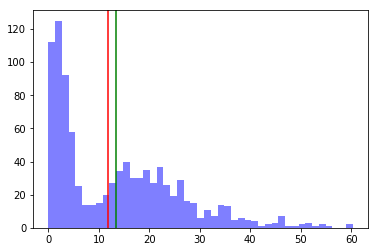

Lifetime Hours Mean: 13.428575536582473 Lifetime Hours Median: 11.725277777777778


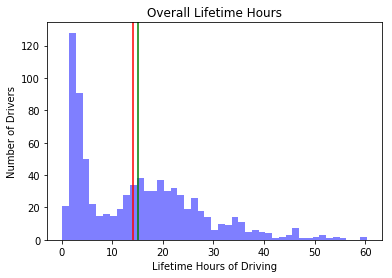

Lifetime Hours Mean Clean: 15.0329453736891 Lifetime Hours Median Clean: 14.051666666666668
6.9591666666666665


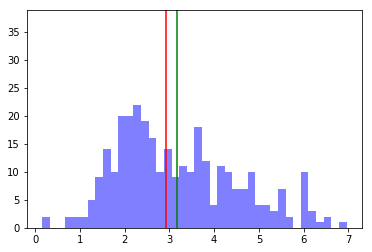

Lifetime Rides Short Mean: 3.1769976925807595 Lifetime Rides Short Median: 2.9125


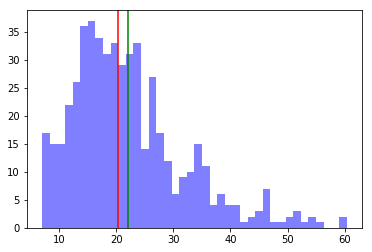

Lifetime Rides Long Mean: 22.11483778625954 Lifetime Rides Long Median: 20.24875


In [199]:
print("Number of hours")

driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

lifetime_hours = list(driver_hours.values())
lifetime_hours_mean = np.mean(np.asarray(lifetime_hours))
lifetime_hours_median = np.median(np.asarray(lifetime_hours))

num_bins = 45
n, bins, patches = plt.hist(lifetime_hours, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean, color='green')
plt.axvline(x=lifetime_hours_median, color='red')
plt.show()
print("Lifetime Hours Mean:", lifetime_hours_mean, "Lifetime Hours Median:", lifetime_hours_median)

lifetime_hours_clean = [x for x in lifetime_hours if x != 0]
lifetime_hours_mean_clean = np.mean(np.asarray(lifetime_hours_clean))
lifetime_hours_median_clean = np.median(np.asarray(lifetime_hours_clean))
n, bins, patches = plt.hist(lifetime_hours_clean, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_mean_clean, color='green')
plt.axvline(x=lifetime_hours_median_clean, color='red')
plt.xlabel("Lifetime Hours of Driving")
plt.ylabel("Number of Drivers")
plt.title("Overall Lifetime Hours")
plt.show()
print("Lifetime Hours Mean Clean:", lifetime_hours_mean_clean, "Lifetime Hours Median Clean:", lifetime_hours_median_clean)

num_bins = 40
lifetime_hours_short = [x for x in lifetime_hours_clean if x < 7]
print(max(lifetime_hours_short))
lifetime_hours_short_mean = np.mean(np.asarray(lifetime_hours_short))
lifetime_hours_short_median = np.median(np.asarray(lifetime_hours_short))
n, bins, patches = plt.hist(lifetime_hours_short, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_short_mean, color='green')
plt.axvline(x=lifetime_hours_short_median, color='red')
plt.ylim(top=38.85)
plt.show()
print("Lifetime Rides Short Mean:", lifetime_hours_short_mean, "Lifetime Rides Short Median:", lifetime_hours_short_median)

lifetime_hours_long = [x for x in lifetime_hours_clean if x >= 7]
lifetime_hours_long_mean = np.mean(np.asarray(lifetime_hours_long))
lifetime_hours_long_median = np.median(np.asarray(lifetime_hours_long))
n, bins, patches = plt.hist(lifetime_hours_long, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=lifetime_hours_long_mean, color='green')
plt.axvline(x=lifetime_hours_long_median, color='red')
plt.show()
print("Lifetime Rides Long Mean:", lifetime_hours_long_mean, "Lifetime Rides Long Median:", lifetime_hours_long_median)

Scatter plot of days vs. rides


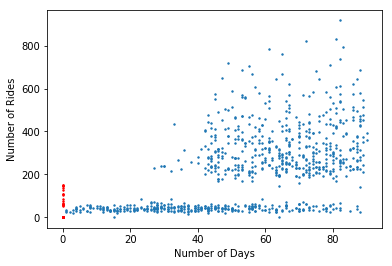

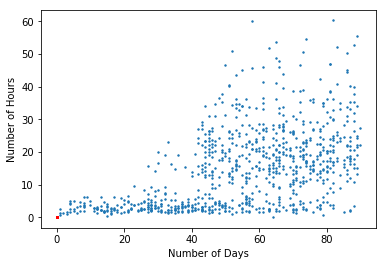

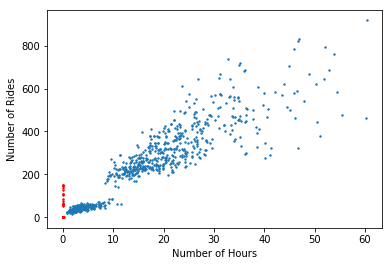

In [10]:
print("Scatter plot of days vs. rides")
x_days_clean = []
y_rides_clean = []
x_days_full = []
y_rides_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_days_full.append(days)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.scatter(x_days_clean,y_rides_clean,s=2)
plt.scatter(x_days_full,y_rides_full,s=2,color='red')
plt.show()

x_days_clean = []
y_hours_clean = []
x_days_full = []
y_hours_full = []
for driver_id, days in driver_days.items():
    if driver_hours[driver_id] != 0:
        x_days_clean.append(days)
        y_hours_clean.append(driver_hours[driver_id])
    else:
        x_days_full.append(days)
        y_hours_full.append(driver_hours[driver_id])
        
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.scatter(x_days_clean,y_hours_clean,s=2)
plt.scatter(x_days_full,y_hours_full,s=2,color='red')
plt.show()

x_hours_clean = []
y_rides_clean = []
x_hours_full = []
y_rides_full = []
for driver_id, hours in driver_hours.items():
    if driver_hours[driver_id] != 0:
        x_hours_clean.append(hours)
        y_rides_clean.append(len(driver_to_ride.get(driver_id,[])))
    else:
        x_hours_full.append(hours)
        y_rides_full.append(len(driver_to_ride.get(driver_id,[])))

plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.scatter(x_hours_clean,y_rides_clean,s=2)
plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
plt.show()

In [11]:
driver_hours = {}
for driver_id, onboard_date in driver_ids:
    num_seconds = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            num_seconds += (ride_timestamps_map[ride_id]['arrived_at'] - ride_timestamps_map[ride_id]['accepted_at']).seconds
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_hours[driver_id] = num_seconds / 60 / 60

Heatmap plot of days vs. rides


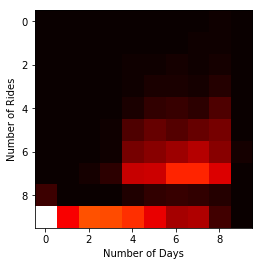

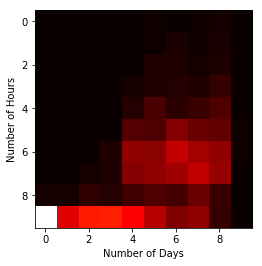

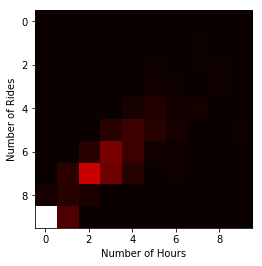

In [12]:
print("Heatmap plot of days vs. rides")
days_rides_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_rides = len(driver_to_ride.get(driver_id,[]))
    days_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_days/10))] += 1

plt.xlabel('Number of Days')
plt.ylabel('Number of Rides')
plt.imshow(days_rides_heatmap, cmap='hot')
plt.show()

days_hours_heatmap = np.zeros((10,10))
for driver_id, days in driver_days.items():
    x_days = days
    y_hours = driver_hours[driver_id]
    days_hours_heatmap[max(0,9-int(y_hours/6)),min(9,int(x_days/10))] += 1
    
plt.xlabel('Number of Days')
plt.ylabel('Number of Hours')
plt.imshow(days_hours_heatmap, cmap='hot')
plt.show()

hours_rides_heatmap = np.zeros((10,10))
for driver_id, hours in driver_hours.items():
    x_hours = hours
    y_rides = len(driver_to_ride.get(driver_id,[]))
    hours_rides_heatmap[max(0,9-int(y_rides/100)),min(9,int(x_hours/6))] += 1
    
plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.imshow(hours_rides_heatmap, cmap='hot')
plt.show()

Scatterplot


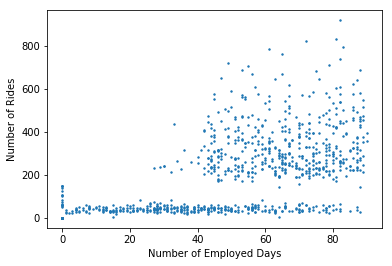

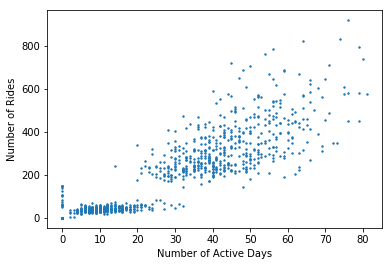

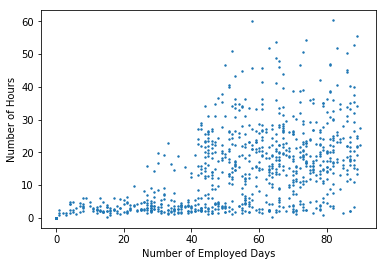

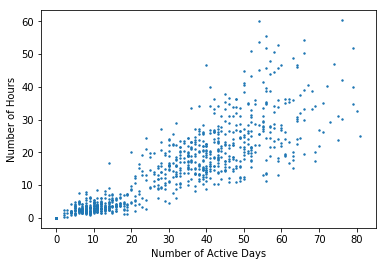

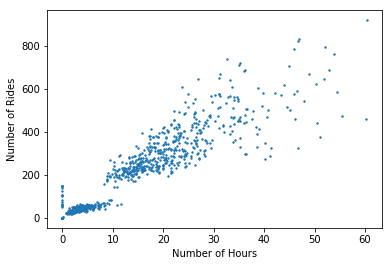

In [13]:
print("Scatterplot")
x = []
y = []
for driver_id, days in driver_days.items():
    x_days = days
    y_rides = len(driver_to_ride.get(driver_id,[]))
    x.append(x_days)
    y.append(y_rides)

plt.xlabel('Number of Employed Days')
plt.ylabel('Number of Rides')
plt.scatter(x, y, s=2)
plt.show()

x = []
y = []
for driver_id, days in driver_days_active.items():
    x_days = days
    y_rides = len(driver_to_ride.get(driver_id,[]))
    x.append(x_days)
    y.append(y_rides)

plt.xlabel('Number of Active Days')
plt.ylabel('Number of Rides')
plt.scatter(x, y, s=2)
plt.show()

x = []
y = []
for driver_id, days in driver_days.items():
    x_days = days
    y_hours = driver_hours[driver_id]
    x.append(x_days)
    y.append(y_hours)
    
plt.xlabel('Number of Employed Days')
plt.ylabel('Number of Hours')
plt.scatter(x, y, s=2)
plt.show()

x = []
y = []
for driver_id, days in driver_days_active.items():
    x_days = days
    y_hours = driver_hours[driver_id]
    x.append(x_days)
    y.append(y_hours)
    
plt.xlabel('Number of Active Days')
plt.ylabel('Number of Hours')
plt.scatter(x, y, s=2)
plt.show()

x = []
y = []
for driver_id, hours in driver_hours.items():
    x_hours = hours
    y_rides = len(driver_to_ride.get(driver_id,[]))
    x.append(x_hours)
    y.append(y_rides)
    
plt.xlabel('Number of Hours')
plt.ylabel('Number of Rides')
plt.scatter(x, y, s=2)
plt.show()

## Categories of Drivers

Day of week


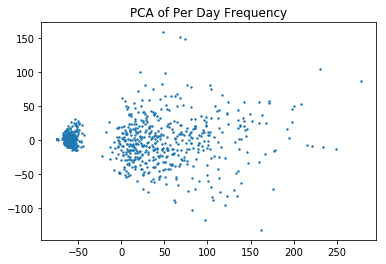

Component 1 (count): [0.28132626 0.32709573 0.36623304 0.3997014  0.44944649 0.45488873
 0.33324191]
Component 2 (weekend): [-0.21418311 -0.33965469 -0.31149743 -0.28765337 -0.10146957  0.54830229
  0.58996076]
Component 3 (??): [ 0.51230235  0.28849935  0.04305716 -0.12423998 -0.52027016 -0.31455726
  0.51710505]
Explained Variance: [4826.64440583  764.43579472  246.77917925  162.57920483  137.18888002
  115.85724781  108.42134342]


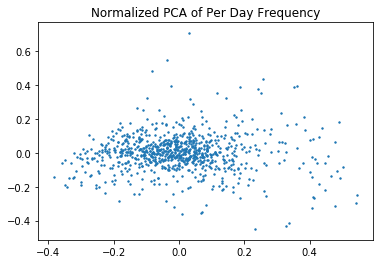

Component 1 (weekend): [-0.16262872 -0.3044233  -0.36979355 -0.32882914  0.04139462  0.59594908
  0.52833101]
Component 2 (friday night?): [-0.21889466 -0.19760977 -0.09491803  0.05693102  0.75502086  0.22760396
 -0.52813338]
Component 3 (??): [ 0.04547594  0.07528676 -0.2634863  -0.18097607  0.52157315 -0.64596094
  0.44808746]
Explained Variance: [2.48248895e-02 1.30048971e-02 8.63469449e-03 7.94540903e-03
 6.83754691e-03 5.85065974e-03 1.29577964e-31]


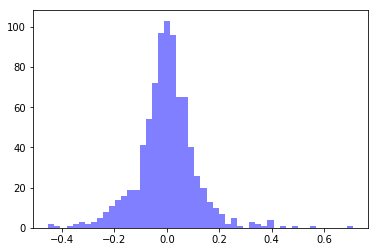

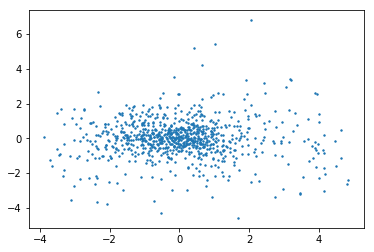

Component 1 (weekend): [-0.16262872 -0.3044233  -0.36979355 -0.32882914  0.04139462  0.59594908
  0.52833101]
Component 2 (friday night?): [-0.21889466 -0.19760977 -0.09491803  0.05693102  0.75502086  0.22760396
 -0.52813338]
Component 3 (??): [ 0.04547594  0.07528676 -0.2634863  -0.18097607  0.52157315 -0.64596094
  0.44808746]
Explained Variance: [2.48248895e-02 1.30048971e-02 8.63469449e-03 7.94540903e-03
 6.83754691e-03 5.85065974e-03 1.29577964e-31]


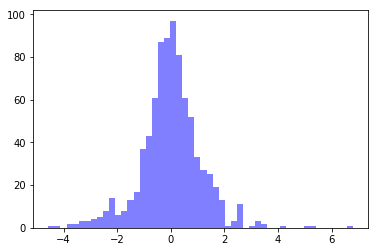

In [190]:
print("Day of week")

# Full
driver_weekday = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = weekday_counts
    
X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.title("PCA of Per Day Frequency")
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (weekend):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        for i in range(7):
            weekday_counts[i] = weekday_counts[i] / total
        driver_weekday_clean[driver_id] = weekday_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=7)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.title("Normalized PCA of Per Day Frequency")
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_clean[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Normed
driver_weekday_norm = driver_weekday_clean
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=7))])
X_pca_norm = pipeline.fit_transform(X_norm)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (weekend):", pca.components_[0])
print("Component 2 (friday night?):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

num_bins = 50
n, bins, patches = plt.hist(X_pca_norm[:,1], num_bins, facecolor='blue', alpha=0.5)
plt.show()

Percentage of weekend rides
Only week days percentage: 5.734767025089606
Only weekend percentage: 0.23894862604540024


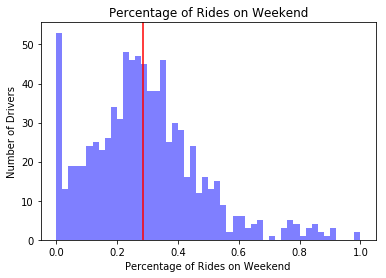

In [191]:
print("Percentage of weekend rides")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        total = sum(weekday_counts)
        driver_weekday_clean[driver_id] = (weekday_counts[5]+weekday_counts[6])/total
        
print("Only week days percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
print("Only weekend percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)


weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=2/7, color='red')
plt.ylabel("Number of Drivers")
plt.xlabel("Percentage of Rides on Weekend")
plt.title("Percentage of Rides on Weekend")
plt.show()

Entropy of week


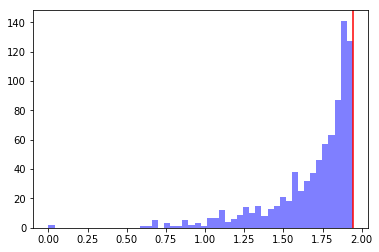

Entropy of week vs. weekend
Just weekend or just weekdays percentage: 5.973715651135006


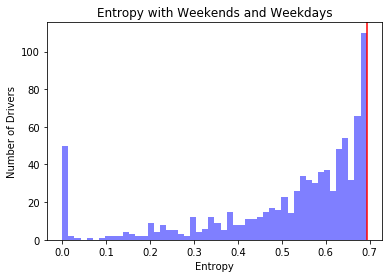

In [192]:
print("Entropy of week")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        for i in range(7):
            if weekday_counts[i] > 0:
                entropy -= weekday_counts[i]/total * math.log(weekday_counts[i]/total)
        driver_weekday_clean[driver_id] = entropy
                
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(7), color='red')
plt.show()

print("Entropy of week vs. weekend")

driver_weekday_clean = {} # Note: [0] is Monday
for driver_id, onboard_date in driver_ids:
    weekday_counts = [0 for x in range(7)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(weekday_counts) > 0:
        entropy = 0
        total = sum(weekday_counts)
        weekday = np.sum(np.asarray(weekday_counts)[:5])
        weekend = np.sum(np.asarray(weekday_counts)[5:])
        if weekday > 0:
            entropy -= weekday/total*math.log(weekday/total)
        if weekend > 0:
            entropy -= weekend/total*math.log(weekend/total)
        driver_weekday_clean[driver_id] = entropy 
        
print("Just weekend or just weekdays percentage:",len([x for x in driver_weekday_clean.values() if x < .001])/len(driver_weekday_clean.values())*100)
        
weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=math.log(2), color='red')
plt.ylabel("Number of Drivers")
plt.xlabel("Entropy")
plt.title("Entropy with Weekends and Weekdays")
plt.show()

Hour of day


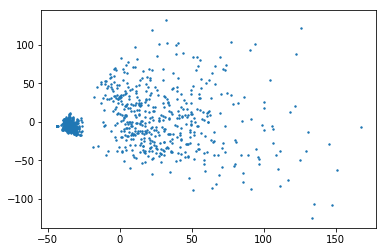

Component 1 (count): [0.16886712 0.12407257 0.06558523 0.02778441 0.01929102 0.02520159
 0.05767338 0.13572776 0.17425706 0.17917289 0.14792774 0.14316655
 0.13250953 0.13545515 0.14663947 0.17698335 0.21474736 0.28069323
 0.355469   0.36126898 0.33157421 0.31765501 0.29961319 0.22866422]
Component 2 (day): [-0.20834519 -0.17243879 -0.0980631  -0.05124255 -0.02143862  0.0235173
  0.11509298  0.24244031  0.30572512  0.35344589  0.31147649  0.28161993
  0.25536862  0.21839056  0.17598449  0.14477269  0.10981327  0.06628768
 -0.01412321 -0.10841353 -0.18862009 -0.26264331 -0.29000698 -0.2548589 ]
Component 3 (afternoon): [ 0.20785648  0.19827742  0.13899187  0.09011566  0.07939437  0.10084261
  0.18937949  0.29526419  0.31608927  0.3065955   0.18027967  0.09110444
 -0.04239152 -0.14821941 -0.21369494 -0.28796631 -0.31666229 -0.29745619
 -0.23651012 -0.16152714 -0.03227512  0.0952837   0.19027844  0.21527652]
Explained Variance: [1.73630968e+03 9.01535825e+02 3.52662783e+02 2.16801402e+02


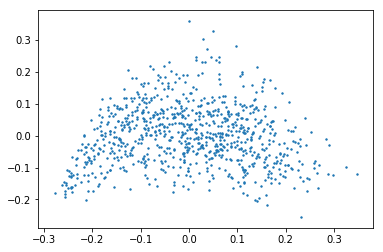

Component 1 (day): [ 0.19457996  0.14170614  0.08058725  0.03834601  0.01374288 -0.02243225
 -0.07713766 -0.16881445 -0.23238391 -0.28575661 -0.25745461 -0.24195908
 -0.21883184 -0.18697058 -0.16591912 -0.13007666 -0.07837001 -0.01294938
  0.07575291  0.18963951  0.29421915  0.40091668  0.37424981  0.27531583]
Component 2 (afternoon): [-0.19367298 -0.16466663 -0.11191    -0.07369242 -0.05364966 -0.05447357
 -0.09960515 -0.14741137 -0.18999493 -0.19908492 -0.16405456 -0.10693946
 -0.00521982  0.08325451  0.13746997  0.21701529  0.32678786  0.39047991
  0.4474351   0.32787889  0.15552111 -0.08875007 -0.20548982 -0.22722727]
Component 3 (??): [ 0.16745253  0.13715931  0.08242208  0.05568797  0.01379954 -0.05423443
 -0.15604283 -0.28379184 -0.35506403 -0.30736802 -0.09693424  0.10426514
  0.20611886  0.29951388  0.37455647  0.30314915  0.11743639 -0.07110389
 -0.26176655 -0.24435493 -0.20036806 -0.0800673   0.07346027  0.17607454]
Explained Variance: [1.63378898e-02 9.05126438e-03 5.356611

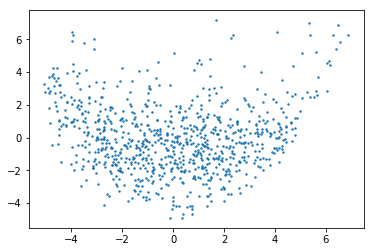

Component 1 (day): [ 0.19457996  0.14170614  0.08058725  0.03834601  0.01374288 -0.02243225
 -0.07713766 -0.16881445 -0.23238391 -0.28575661 -0.25745461 -0.24195908
 -0.21883184 -0.18697058 -0.16591912 -0.13007666 -0.07837001 -0.01294938
  0.07575291  0.18963951  0.29421915  0.40091668  0.37424981  0.27531583]
Component 2 (afternoon): [-0.19367298 -0.16466663 -0.11191    -0.07369242 -0.05364966 -0.05447357
 -0.09960515 -0.14741137 -0.18999493 -0.19908492 -0.16405456 -0.10693946
 -0.00521982  0.08325451  0.13746997  0.21701529  0.32678786  0.39047991
  0.4474351   0.32787889  0.15552111 -0.08875007 -0.20548982 -0.22722727]
Component 3 (??): [ 0.16745253  0.13715931  0.08242208  0.05568797  0.01379954 -0.05423443
 -0.15604283 -0.28379184 -0.35506403 -0.30736802 -0.09693424  0.10426514
  0.20611886  0.29951388  0.37455647  0.30314915  0.11743639 -0.07110389
 -0.26176655 -0.24435493 -0.20036806 -0.0800673   0.07346027  0.17607454]
Explained Variance: [1.63378898e-02 9.05126438e-03 5.356611

In [17]:
print("Hour of day")

# Full
driver_weekday = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    driver_weekday[driver_id] = hour_counts

X = np.asarray([days for driver_id, days in driver_weekday.items()])
pca = PCA(n_components=24)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0],X_pca[:,1],s=2)
plt.show()

print("Component 1 (count):", pca.components_[0])
print("Component 2 (day):", pca.components_[1])
print("Component 3 (afternoon):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Clean
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        for i in range(24):
            hour_counts[i] = hour_counts[i]/total
        driver_weekday_clean[driver_id] = hour_counts

X_clean = np.asarray([days for driver_id, days in driver_weekday_clean.items()])
pca = PCA(n_components=24)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Normed
X_norm = np.asarray([days for driver_id, days in driver_weekday_norm.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=24))])
X_pca_norm = pipeline.fit_transform(X_clean)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (day):", pca.components_[0])
print("Component 2 (afternoon):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

Percentage of out of work day rides
Just workday percentage: 3.464755077658303


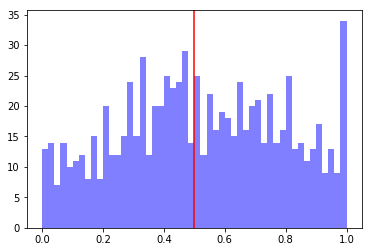

In [18]:
print("Percentage of out of work day rides")
        
driver_weekday_clean = {}
for driver_id, onboard_date in driver_ids:
    hour_counts = [0 for x in range(24)]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            hour_counts[int((ride_timestamps_map[ride_id]['accepted_at'].hour+ride_timestamps_map[ride_id]['arrived_at'].hour)/2)] += 1
        except: # Note: This happens a lot...
            # print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if sum(hour_counts) > 0:
        total = sum(hour_counts)
        driver_weekday_clean[driver_id] = np.sum(np.asarray(hour_counts)[6:18]) / total
        
print("Just workday percentage:",len([x for x in driver_weekday_clean.values() if x > .99])/len(driver_weekday_clean.values())*100)

weekend_percentages = np.asarray(list(driver_weekday_clean.values()))
num_bins = 50
n, bins, patches = plt.hist(weekend_percentages, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=12/24, color='red')
plt.show()

## Cost Analysis Setup

In [19]:
def ride_cost(ride_distance, ride_duration, ride_prime_time):
    cost = 2.0+1.15*(ride_distance/1609.34)+0.22*(ride_duration/60.0)+1.75
    cost = min(max(5.0, cost), 500)
    return cost*((ride_prime_time+100)/100.0)

## Lifetime Value Setup

In [20]:
#total money made, total days active, total days employed, total hours active
#of the form {driver_id -> [total money, total days active, total days employed, total hours active]}
driver_lifetime_metadata = {} 
#data for every day of the form {driver_id -> {day number -> hours, money, or active}}
driver_lifetime_hours = {}
driver_lifetime_money = {}
driver_lifetime_active = {}

for driver_id, onboard_date in driver_ids:
    total_money = 0.0
    total_days_active = set()
    total_days_employed = 0
    total_hours_active = 0
                
    hours_temp = {}
    money_temp = {}
    active_temp = {}
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            ride_money = ride_cost(ride_ids_map[ride_id][0],ride_ids_map[ride_id][1],ride_ids_map[ride_id][2])
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days

            total_money += ride_money
            total_days_active.add(ride_day)
            total_days_employed = max(total_days_employed, ride_day)
            total_hours_active += ride_duration

            if(ride_day in hours_temp):
                hours_temp[ride_day] += ride_duration
                money_temp[ride_day] += ride_money
            else:
                hours_temp[ride_day] = ride_duration
                money_temp[ride_day] = ride_money
            active_temp[ride_day] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    hours_temp = {k: v /60/60 for k, v in hours_temp.items()}
    driver_lifetime_hours[driver_id] = hours_temp
    driver_lifetime_money[driver_id] = money_temp
    driver_lifetime_active[driver_id] = active_temp
    driver_lifetime_metadata[driver_id] = [total_money,len(total_days_active),total_days_employed+1,total_hours_active / 60 / 60]
#print(driver_lifetime_active)

Histogram of (#active/#employed)*100 days


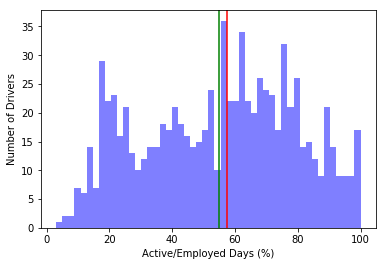

Active/Employed Days Mean: 55.07159105176969 Active/Employed Days Median: 57.333333333333336



In [33]:
print("Histogram of (#active/#employed)*100 days")
active_over_employed = []
for driver_id, onboard_date in driver_ids:
    if(driver_lifetime_metadata[driver_id][1] > 0):
        active_over_employed.append(100*(driver_lifetime_metadata[driver_id][1]+0.0)/driver_lifetime_metadata[driver_id][2])
active_over_employed_mean = np.mean(np.asarray(active_over_employed))
active_over_employed_median = np.median(np.asarray(active_over_employed))
num_bins = 50
n, bins, patches = plt.hist(active_over_employed, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=active_over_employed_mean, color='green')
plt.axvline(x=active_over_employed_median, color='red')
plt.xlabel('Active/Employed Days (%)')
plt.ylabel('Number of Drivers')
plt.show()
print("Active/Employed Days Mean:", active_over_employed_mean, "Active/Employed Days Median:", active_over_employed_median)
print()

## Prime Time Analysis

### Prime Time Demand by Day of Week and Aggregate

Prime Time Demand on Monday


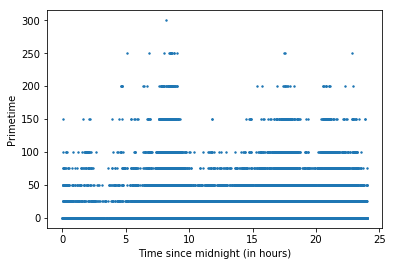

Prime Time Demand on Tuesday


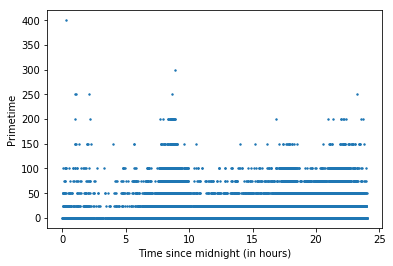

Prime Time Demand on Wednesday


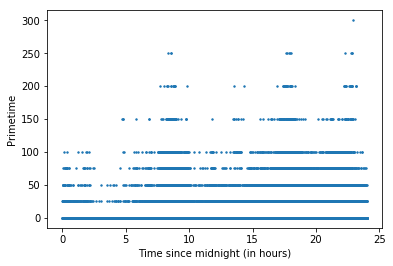

Prime Time Demand on Thursday


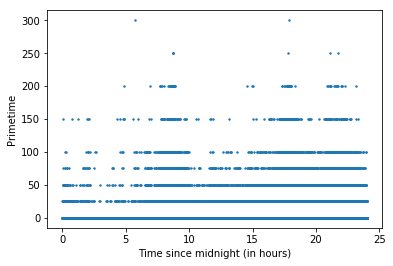

Prime Time Demand on Friday


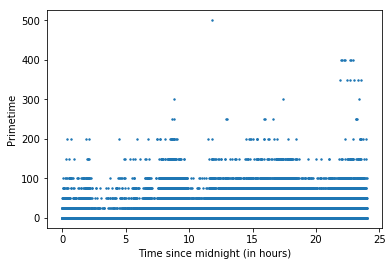

Prime Time Demand on Saturday


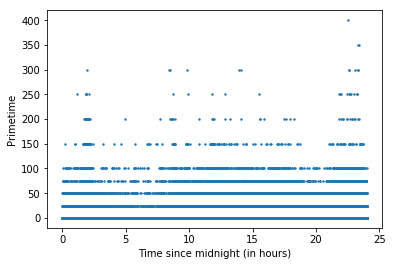

Prime Time Demand on Sunday


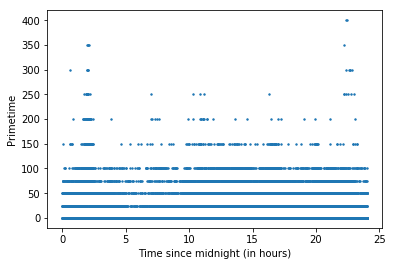

Aggregate Prime Time Demand


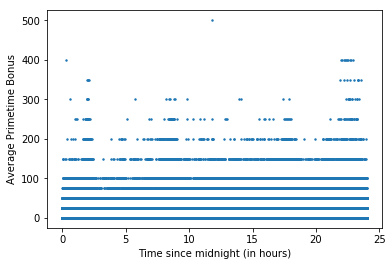

In [22]:
demand_times_by_day = [[0] for l in range(0,7)] #where monday is 0
primetime_by_day = [[0] for l in range(0,7)] #where monday is 0
demand_aggregate_times = [] 
primetime_aggregate = [] 
for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
            now = ride_timestamps_map[ride_id]['requested_at']
            hrs_since_midnight = (now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0

            demand_times_by_day[day].append(hrs_since_midnight)
            primetime_by_day[day].append(ride_prime_time)
            demand_aggregate_times.append(hrs_since_midnight)
            primetime_aggregate.append(ride_prime_time)
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    plt.scatter(demand_times_by_day[counter],primetime_by_day[counter],s=2)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Average Primetime Bonus')
plt.scatter(demand_aggregate_times,primetime_aggregate,s=2)
plt.show()

### Prime Time Demand by Day of Week and Aggregate (Smooth and averaged)

Prime Time Demand on Monday
There were 7047 rides with primetime applied.


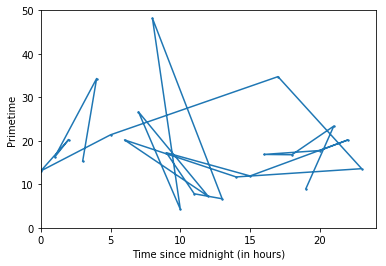

Prime Time Demand on Tuesday
There were 7114 rides with primetime applied.


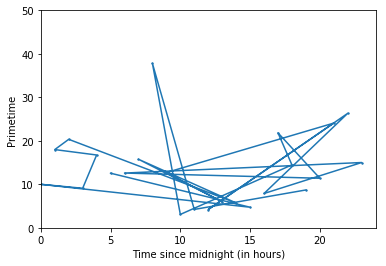

Prime Time Demand on Wednesday
There were 8235 rides with primetime applied.


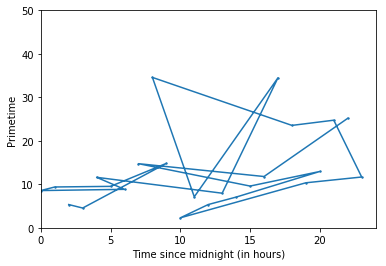

Prime Time Demand on Thursday
There were 9760 rides with primetime applied.


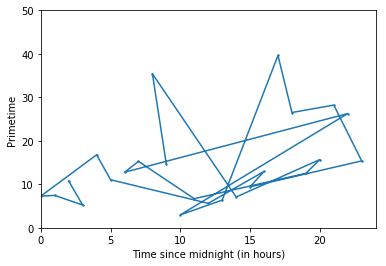

Prime Time Demand on Friday
There were 12067 rides with primetime applied.


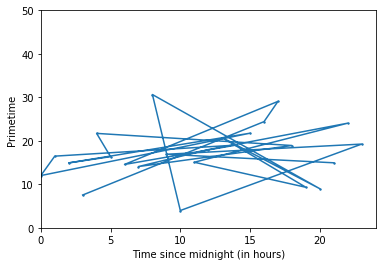

Prime Time Demand on Saturday
There were 10871 rides with primetime applied.


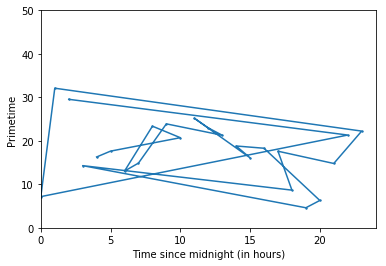

Prime Time Demand on Sunday
There were 10008 rides with primetime applied.


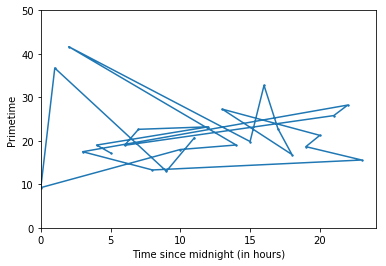

Aggregate Prime Time Demand


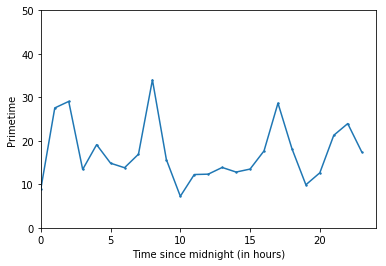

In [23]:
primetime_by_day_smooth = [{} for l in range(0,7)] #where monday is 0
primetime_aggregate_smooth = {}
number_points_per_time = [{} for l in range(0,7)]
number_primetime_by_day = [0 for l in range(0,7)]

for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
            now = ride_timestamps_map[ride_id]['requested_at']
            hrs_since_midnight = (int)((now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0)
            
            if(ride_prime_time > 0):
                number_primetime_by_day[day] += 1
            
            if(hrs_since_midnight in primetime_by_day_smooth[day]):
                primetime_by_day_smooth[day][hrs_since_midnight].append(ride_prime_time)
                primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                number_points_per_time[day][hrs_since_midnight] += 1
            elif(hrs_since_midnight in number_points_per_time):
                primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                number_points_per_time[day][hrs_since_midnight] = 1
            else:
                primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                primetime_aggregate_smooth[hrs_since_midnight] = [ride_prime_time]
                number_points_per_time[day][hrs_since_midnight] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    print("There were " + str(number_primetime_by_day[counter]) + " rides with primetime applied.")
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    x = []
    y = []
    for time in number_points_per_time[counter].keys():
        x.append(time)
        y.append(sum(primetime_by_day_smooth[counter][time])/(0.0+ number_points_per_time[counter][time]))
    plt.scatter(x,y,s=2)
    plt.ylim([0, 50])
    plt.xlim([0, 24])
    plt.plot(x,y)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Primetime')
x = []
y = []
for time in [k for k in range(0,24)]:
    x.append(time)
    y.append(sum(primetime_aggregate_smooth[time])/(sum([number_points_per_time[j][time] for j in range(0,7)])+0.0))
plt.scatter(x,y,s=2)
plt.ylim([0, 50])
plt.xlim([0, 24])
plt.plot(x,y)
plt.show()

### Prime Time Demand by Day of Week and Aggregate (Smooth and averaged) without 0s

Prime Time Demand on Monday


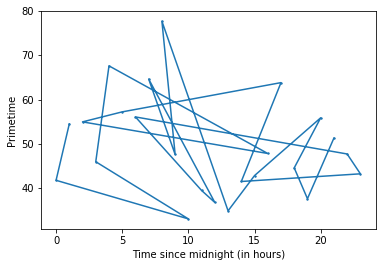

Prime Time Demand on Tuesday


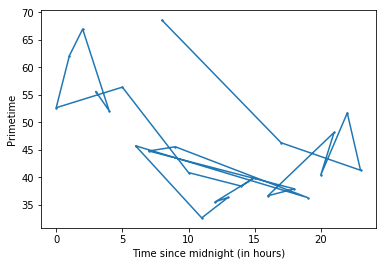

Prime Time Demand on Wednesday


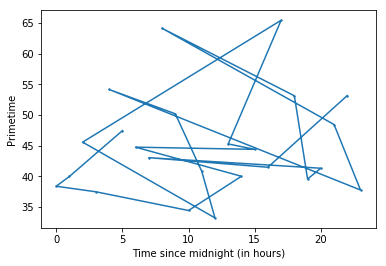

Prime Time Demand on Thursday


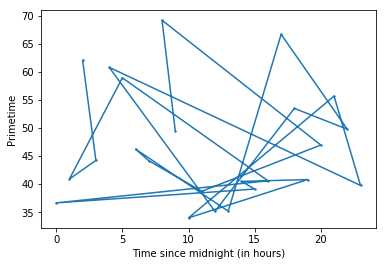

Prime Time Demand on Friday


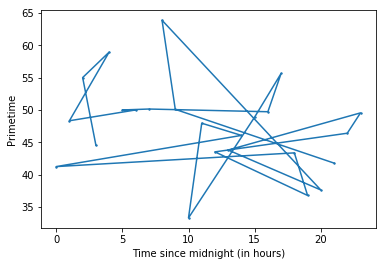

Prime Time Demand on Saturday


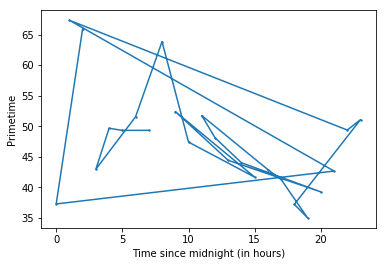

Prime Time Demand on Sunday


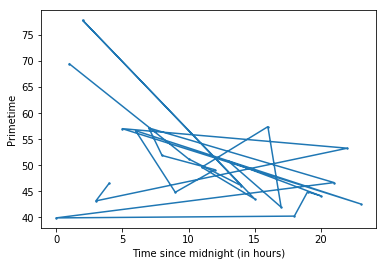

Aggregate Prime Time Demand


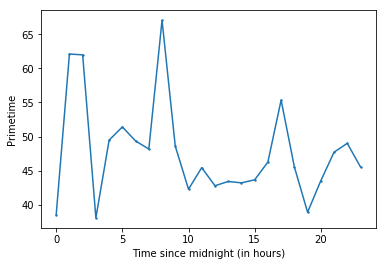

In [24]:
primetime_by_day_smooth = [{} for l in range(0,7)] #where monday is 0
primetime_aggregate_smooth = {}
number_points_per_time = [{} for l in range(0,7)]

for driver_id, onboard_date in driver_ids:
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_prime_time != 0):
                day = ride_timestamps_map[ride_id]['arrived_at'].weekday()
                now = ride_timestamps_map[ride_id]['requested_at']
                hrs_since_midnight = (int)((now - now.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()/60.0/60.0)

                if(hrs_since_midnight in primetime_by_day_smooth[day]):
                    primetime_by_day_smooth[day][hrs_since_midnight].append(ride_prime_time)
                    primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                    number_points_per_time[day][hrs_since_midnight] += 1
                elif(hrs_since_midnight in number_points_per_time):
                    primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                    primetime_aggregate_smooth[hrs_since_midnight].append(ride_prime_time)
                    number_points_per_time[day][hrs_since_midnight] = 1
                else:
                    primetime_by_day_smooth[day][hrs_since_midnight] = [ride_prime_time]
                    primetime_aggregate_smooth[hrs_since_midnight] = [ride_prime_time]
                    number_points_per_time[day][hrs_since_midnight] = 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass

days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for counter in range(0,7):
    print("Prime Time Demand on " + days_of_the_week[counter])
    plt.xlabel('Time since midnight (in hours)')
    plt.ylabel('Primetime')
    x = []
    y = []
    for time in number_points_per_time[counter].keys():
        x.append(time)
        y.append(sum(primetime_by_day_smooth[counter][time])/(0.0+ number_points_per_time[counter][time]))
    plt.scatter(x,y,s=2)
    plt.plot(x,y)
    plt.show()

print("Aggregate Prime Time Demand")
plt.xlabel('Time since midnight (in hours)')
plt.ylabel('Primetime')
x = []
y = []
for time in [k for k in range(0,24)]:
    x.append(time)
    y.append(sum(primetime_aggregate_smooth[time])/(sum([number_points_per_time[j][time] for j in range(0,7)])+0.0))
plt.scatter(x,y,s=2)
plt.plot(x,y)
plt.show()

Percent of a Driver's Rides that are Primetime > 0


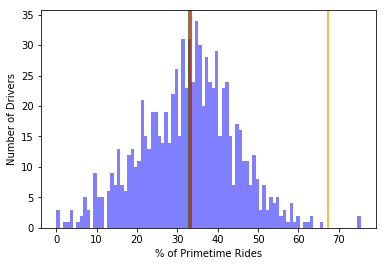

Percent Primetime Rides Mean: 32.77197433269769 Percent Primetime Rides Median: 33.333333333333336
Average Percent non-Primetime Rides 67.22802566730232


In [25]:
percent_prime_time = []
average_percent_non_primetime = []
for driver_id, onboard_date in driver_ids:
    prime_time_number = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            if(ride_ids_map[ride_id][2] > 0):
                prime_time_number += 1
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        percent_prime_time.append(100.0*(prime_time_number+0.0)/total_rides)
        average_percent_non_primetime.append(100.0-(100.0*(prime_time_number+0.0)/total_rides))

percent_primetime_mean = np.mean(np.asarray(percent_prime_time))
percent_primetime_median = np.median(np.asarray(percent_prime_time))        
num_bins = 90
print("Percent of a Driver's Rides that are Primetime > 0")
plt.xlabel('% of Primetime Rides')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(percent_prime_time, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=percent_primetime_mean, color='green')
plt.axvline(x=percent_primetime_median, color='red')
plt.axvline(x=np.mean(np.asarray(average_percent_non_primetime)), color='orange')
plt.show()
print("Percent Primetime Rides Mean:", percent_primetime_mean, "Percent Primetime Rides Median:", percent_primetime_median)
print("Average Percent non-Primetime Rides", np.mean(np.asarray(average_percent_non_primetime)))

Percent of a Driver's Rides that are Primetime greater than 0
Percent less than the mean: 47.07259953161593
Percent of 0% primetime rides greater than threshold: 0.351288056206089


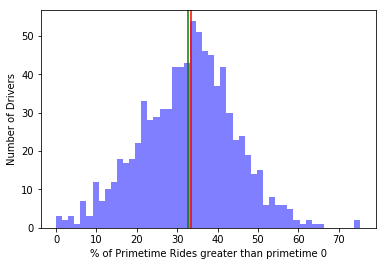

Percent Primetime Rides Mean: 32.77197433269769 Percent Primetime Rides Median: 33.333333333333336


Percent of a Driver's Rides that are Primetime greater than 25
Percent less than the mean: 48.94613583138173
Percent of 0% primetime rides greater than threshold: 1.873536299765808


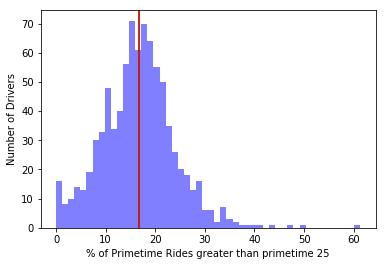

Percent Primetime Rides Mean: 16.655695888603525 Percent Primetime Rides Median: 16.706809546900562


Percent of a Driver's Rides that are Primetime greater than 50
Percent less than the mean: 54.332552693208434
Percent of 0% primetime rides greater than threshold: 6.0889929742388755


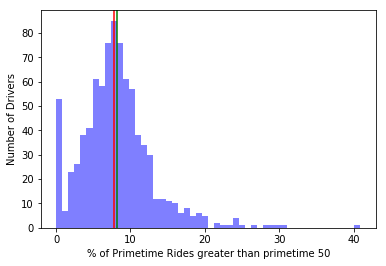

Percent Primetime Rides Mean: 8.136216459552186 Percent Primetime Rides Median: 7.818784795290483


Percent of a Driver's Rides that are Primetime greater than 75
Percent less than the mean: 54.91803278688525
Percent of 0% primetime rides greater than threshold: 13.23185011709602


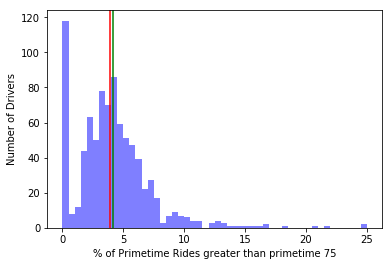

Percent Primetime Rides Mean: 4.143058151034996 Percent Primetime Rides Median: 3.8703886438481563


Percent of a Driver's Rides that are Primetime greater than 100
Percent less than the mean: 61.35831381733021
Percent of 0% primetime rides greater than threshold: 32.55269320843091


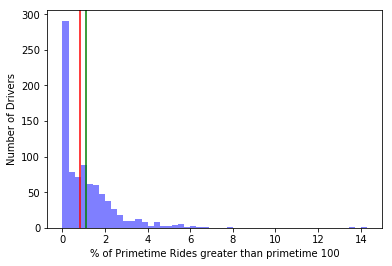

Percent Primetime Rides Mean: 1.1193364583573844 Percent Primetime Rides Median: 0.819672131147541


Percent of a Driver's Rides that are Primetime greater than 150
Percent less than the mean: 69.3208430913349
Percent of 0% primetime rides greater than threshold: 62.997658079625296


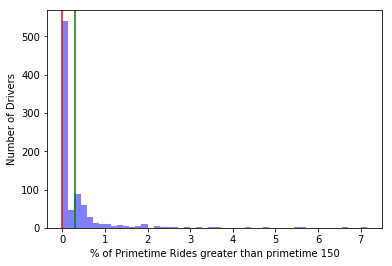

Percent Primetime Rides Mean: 0.294276016639451 Percent Primetime Rides Median: 0.0


Percent of a Driver's Rides that are Primetime greater than 200
Percent less than the mean: 86.18266978922716
Percent of 0% primetime rides greater than threshold: 86.18266978922716


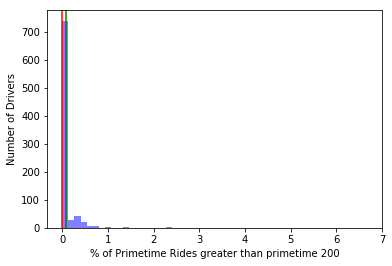

Percent Primetime Rides Mean: 0.08304215221416326 Percent Primetime Rides Median: 0.0


Percent of a Driver's Rides that are Primetime greater than 250
Percent less than the mean: 95.08196721311475
Percent of 0% primetime rides greater than threshold: 95.08196721311475


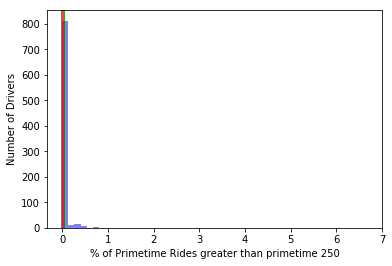

Percent Primetime Rides Mean: 0.032113445991336635 Percent Primetime Rides Median: 0.0


Percent of a Driver's Rides that are Primetime greater than 300
Percent less than the mean: 98.00936768149883
Percent of 0% primetime rides greater than threshold: 98.00936768149883


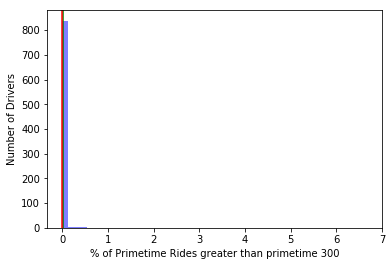

Percent Primetime Rides Mean: 0.018378356762163418 Percent Primetime Rides Median: 0.0


Percent of a Driver's Rides that are Primetime greater than 350
Percent less than the mean: 99.06323185011709
Percent of 0% primetime rides greater than threshold: 99.06323185011709


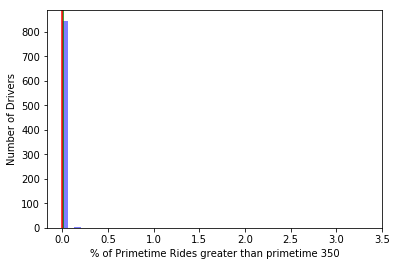

Percent Primetime Rides Mean: 0.010254455253758331 Percent Primetime Rides Median: 0.0


Percent of a Driver's Rides that are Primetime greater than 400
Percent less than the mean: 99.88290398126463
Percent of 0% primetime rides greater than threshold: 99.88290398126463


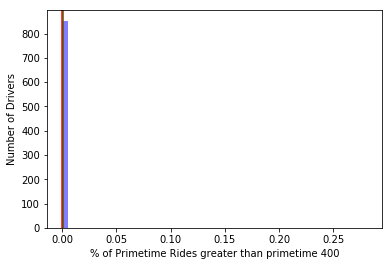

Percent Primetime Rides Mean: 0.0003289214009420309 Percent Primetime Rides Median: 0.0




In [26]:
thresholds = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]
for thres in thresholds:
    percent_prime_time = []
    for driver_id, onboard_date in driver_ids:
        prime_time_number = 0
        total_rides = 0
        for ride_id in driver_to_ride.get(driver_id,[]):
            try:
                if(ride_ids_map[ride_id][2] > thres):
                    prime_time_number += 1
                total_rides += 1
            except: # Note: This happens a lot...
                #print("Missing data... ride_id:",ride_id,"does not exist.")
                pass
        if(total_rides > 0):
            percent_prime_time.append(100.0*(prime_time_number+0.0)/total_rides)
    
    percent_primetime_mean = np.mean(np.asarray(percent_prime_time))
    percent_lessthan_mean = (len([i for i in percent_prime_time if i < percent_primetime_mean])+0.0)/len(percent_prime_time)
    percent_zero = (len([i for i in percent_prime_time if i == 0])+0.0)/len(percent_prime_time)
    percent_primetime_median = np.median(np.asarray(percent_prime_time))        
    num_bins = 50
    print("Percent of a Driver's Rides that are Primetime greater than " + str(thres))
    print("Percent less than the mean: " + str(percent_lessthan_mean*100))
    print("Percent of 0% primetime rides greater than threshold: " + str(percent_zero*100))
    plt.xlabel('% of Primetime Rides greater than primetime ' + str(thres))
    plt.ylabel('Number of Drivers')
    n, bins, patches = plt.hist(percent_prime_time, num_bins, facecolor='blue', alpha=0.5)
    plt.axvline(x=percent_primetime_mean, color='green')
    plt.axvline(x=percent_primetime_median, color='red')
    plt.show()
    print("Percent Primetime Rides Mean:", percent_primetime_mean, "Percent Primetime Rides Median:", percent_primetime_median)
    print("")
    print("")

## Monetary Analysis

### Average ride value for each driver

Average Ride Monetary Value per Driver


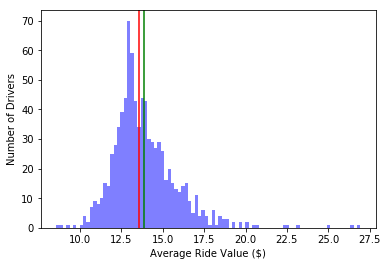

Average Ride Value Mean: 13.899878645423211 Average Ride Value Median: 13.552039757405044


In [27]:
average_ride_value = []
for driver_id, onboard_date in driver_ids:
    ride_value = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]

            ride_value = ride_value + ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        average_ride_value.append((ride_value+0.0)/total_rides)

average_ride_value_mean = np.mean(np.asarray(average_ride_value))
average_ride_value_median = np.median(np.asarray(average_ride_value))        
num_bins = 90
print("Average Ride Monetary Value per Driver")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

Average Ride Monetary Value per Driver on Weekend


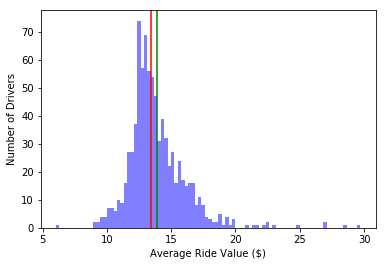

Average Ride Value Mean: 13.860685980108473 Average Ride Value Median: 13.419012066832959
Average Ride Monetary Value per Driver on Weekday


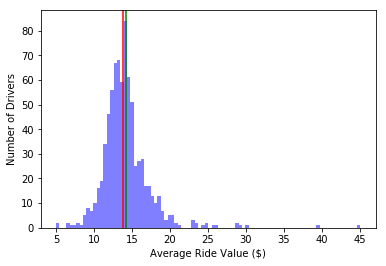

Average Ride Value Mean: 14.15025614622231 Average Ride Value Median: 13.841539124380928


In [28]:
average_ride_value = [[] for l in range(2)] #weekday and then weekend
for driver_id, onboard_date in driver_ids:
    ride_value = [0,0]
    total_rides = [0,0]
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_timestamps_map[ride_id]['arrived_at'].weekday()== 5 or ride_timestamps_map[ride_id]['arrived_at'].weekday()== 6):
                ride_value[1] += ride_cost(ride_distance,ride_duration,ride_prime_time)
                total_rides[1] += 1
            else:
                ride_value[0] += ride_cost(ride_distance,ride_duration,ride_prime_time)
                total_rides[0] += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides[0] > 0):
        average_ride_value[0].append((ride_value[0]+0.0)/total_rides[0])
    if(total_rides[1] > 0):
        average_ride_value[1].append((ride_value[1]+0.0)/total_rides[1])

average_ride_value_mean = np.mean(np.asarray(average_ride_value[0]))
average_ride_value_median = np.median(np.asarray(average_ride_value[0]))        
num_bins = 90
print("Average Ride Monetary Value per Driver on Weekend")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value[0], num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

average_ride_value_mean = np.mean(np.asarray(average_ride_value[1]))
average_ride_value_median = np.median(np.asarray(average_ride_value[1]))
print("Average Ride Monetary Value per Driver on Weekday")
plt.xlabel('Average Ride Value ($)')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(average_ride_value[1], num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

### Average Primetime Value and Percent Primetime Rides by Average Ride Value

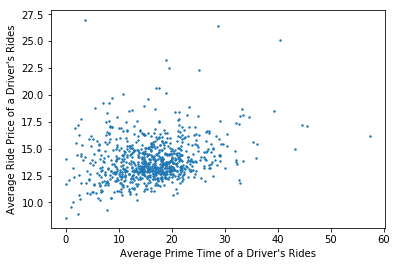

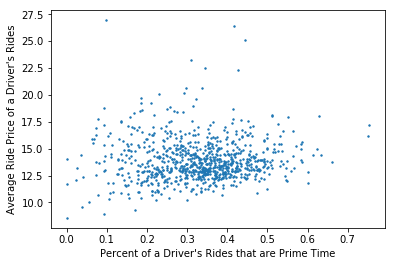

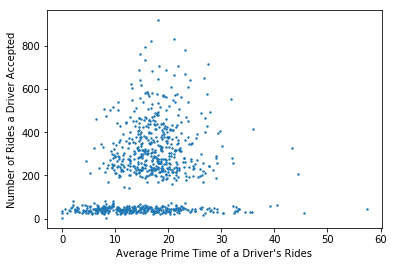

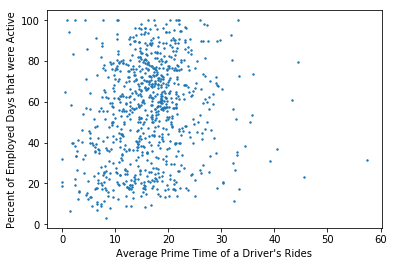

In [29]:
average_ride_value = []
average_prime_time = []
percent_prime_time_list = []
number_of_rides = []
percent_employed = []
for driver_id, onboard_date in driver_ids:
    ride_value = 0
    prime_time = 0
    percent_prime_time = 0
    total_rides = 0
    active_temp = set()
    employed_days = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            
            if(ride_prime_time > 0):
                percent_prime_time += 1
            
            prime_time += ride_prime_time
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
            employed_days = max(employed_days, ride_day+1)
            active_temp.add(ride_day)
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        average_ride_value.append((ride_value+0.0)/total_rides)
        average_prime_time.append((prime_time+0.0)/total_rides)
        percent_prime_time_list.append((percent_prime_time+0.0)/total_rides)
        number_of_rides.append(total_rides)
        percent_employed.append((100*len(active_temp)+0.0)/employed_days)

#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(average_prime_time, average_ride_value)
#print("r^2 value of line of best fit: "+str(r_value**2)) 
plt.xlabel('Average Prime Time of a Driver\'s Rides')
plt.ylabel('Average Ride Price of a Driver\'s Rides')
plt.scatter(average_prime_time,average_ride_value,s=2)
#plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
#plt.plot(np.unique(average_prime_time), np.poly1d(np.polyfit(average_prime_time, average_ride_value, 1))(np.unique(average_prime_time)), color='red')
plt.show()

plt.xlabel('Percent of a Driver\'s Rides that are Prime Time')
plt.ylabel('Average Ride Price of a Driver\'s Rides')
plt.scatter(percent_prime_time_list,average_ride_value,s=2)
#plt.plot(np.unique(percent_prime_time_list), np.poly1d(np.polyfit(percent_prime_time_list, average_ride_value, 1))(np.unique(percent_prime_time_list)))
plt.show()

plt.xlabel('Average Prime Time of a Driver\'s Rides')
plt.ylabel('Number of Rides a Driver Accepted')
plt.scatter(average_prime_time,number_of_rides,s=2)
plt.show()

plt.xlabel('Average Prime Time of a Driver\'s Rides')
plt.ylabel('Percent of Employed Days that were Active')
plt.scatter(average_prime_time,percent_employed,s=2)
plt.show()

Average Ride Price of a Driver's Rides for 0% Greater than Primetime Threshold12.22980502769242
Average Ride Price of a Driver's Rides for some% Greater than Primetime Threshold13.931765492539773


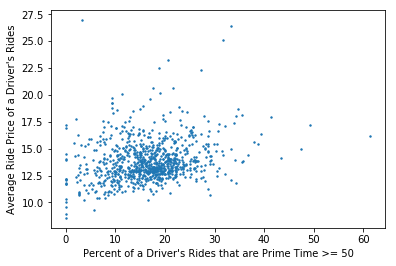

In [30]:
average_ride_value = []
percent_prime_time_list = []
average_zero = []
average_above = []
for driver_id, onboard_date in driver_ids:
    ride_value = 0
    prime_time = 0
    percent_prime_time = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_prime_time > 25):
                percent_prime_time += 1
            
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        average_ride_value.append((ride_value+0.0)/total_rides)
        percent_prime_time_list.append((100*percent_prime_time+0.0)/total_rides)
        if((100*percent_prime_time+0.0)/total_rides - 0 < 0.05):
            average_zero.append((ride_value+0.0)/total_rides)
        else:
            average_above.append((ride_value+0.0)/total_rides)

print("Average Ride Price of a Driver's Rides for 0% Greater than Primetime Threshold" + str(sum(average_zero)/len(average_zero)))
print("Average Ride Price of a Driver's Rides for some% Greater than Primetime Threshold" + str(sum(average_above)/len(average_above)))
plt.xlabel('Percent of a Driver\'s Rides that are Prime Time >= 50')
plt.ylabel('Average Ride Price of a Driver\'s Rides')
plt.scatter(percent_prime_time_list,average_ride_value,s=2)
#plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
plt.show()

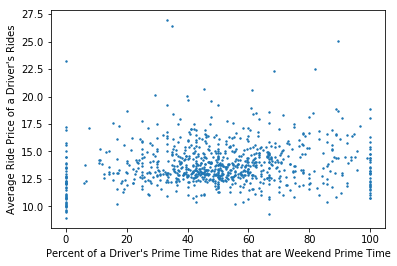

In [31]:
average_ride_value = []
percent_prime_time_list = []
for driver_id, onboard_date in driver_ids:
    ride_value = 0
    percent_prime_time = 0
    prime_time_rides = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if(ride_prime_time > 0):
                prime_time_rides += 1
                if(ride_timestamps_map[ride_id]['arrived_at'].weekday()== 5 or 
                  ride_timestamps_map[ride_id]['arrived_at'].weekday() == 6 or 
                   ride_timestamps_map[ride_id]['arrived_at'].weekday() == 4):
                    percent_prime_time += 1
            
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0 and prime_time_rides > 0):
        average_ride_value.append((ride_value+0.0)/total_rides)
        percent_prime_time_list.append((100*percent_prime_time+0.0)/prime_time_rides)

plt.xlabel('Percent of a Driver\'s Prime Time Rides that are Weekend Prime Time')
plt.ylabel('Average Ride Price of a Driver\'s Rides')
plt.scatter(percent_prime_time_list,average_ride_value,s=2)
#plt.scatter(x_hours_full,y_rides_full,s=2,color='red')
plt.show()

### percent active days and average ride price

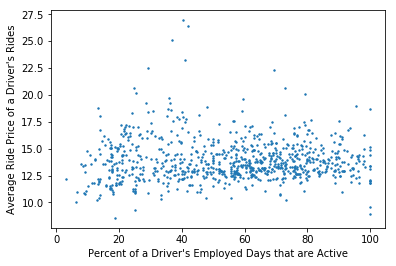

In [32]:
percent_employed = []
average_ride_value = []
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    employed_days = 0
    ride_value = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            employed_days = max(employed_days, ride_day+1)
            active_temp.add(ride_day)
            
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if(total_rides > 0):
        average_ride_value.append((0.0+ride_value)/total_rides)
        percent_employed.append((100*len(active_temp)+0.0)/employed_days)
        if(len(active_temp) > employed_days):
            print(len(active_temp), employed_days)
#print(driver_lifetime_active)

plt.xlabel('Percent of a Driver\'s Employed Days that are Active')
plt.ylabel('Average Ride Price of a Driver\'s Rides')
plt.scatter(percent_employed,average_ride_value,s=2)
plt.show()

### Quanitfying Prime Time

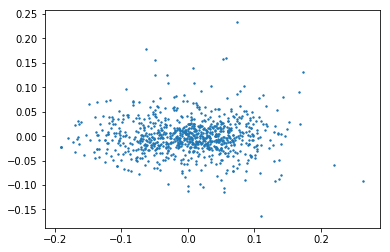

Component 1 (??): [0.89733919 0.38413787 0.1595554  0.14752137]
Component 2 (??): [-0.42615011  0.68476017  0.25488791  0.53341517]
Component 3 (??): [ 0.08571122 -0.61930237  0.37728129  0.6832108 ]
Explained Variance: [0.00461466 0.00141871 0.00081232 0.00048384]


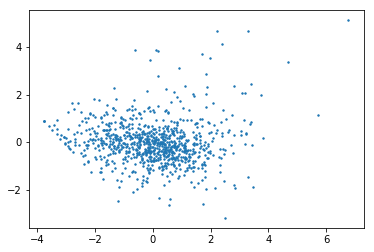

Component 1 (??): [0.89733919 0.38413787 0.1595554  0.14752137]
Component 2 (??): [-0.42615011  0.68476017  0.25488791  0.53341517]
Component 3 (??): [ 0.08571122 -0.61930237  0.37728129  0.6832108 ]
Explained Variance: [0.00461466 0.00141871 0.00081232 0.00048384]


In [58]:
driver_prime_times = {}
for driver_id, onboard_date in driver_ids:
    total_rides = 0
    prime_time = [0 for x in range(0,101,25)]
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_prime_time = int(ride_ids_map[ride_id][2]/25)
            if ride_prime_time > 4:
                ride_prime_time = 4
            prime_time[ride_prime_time] += 1
            total_rides += 1

        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if total_rides > 0:
        for i in range(5):
            prime_time[i] = prime_time[i]/total_rides
        driver_prime_times[driver_id] = np.asarray(prime_time)[1:]
        
X_clean = np.asarray([days for driver_id, days in driver_prime_times.items()])
pca = PCA(n_components=4)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (??):", pca.components_[0])
print("Component 2 (??):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Normed
X_norm = np.asarray([days for driver_id, days in driver_prime_times.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=4))])
X_pca_norm = pipeline.fit_transform(X_clean)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (??):", pca.components_[0])
print("Component 2 (??):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

### Overall PCA

937
837


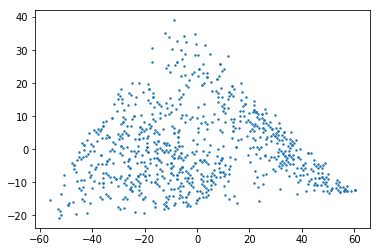

Component 1 (??): [-6.43111778e-01 -7.65769044e-01 -2.23765221e-03 -6.68484533e-05]
Component 2 (??): [-7.65765384e-01  6.43115519e-01 -2.31170501e-03 -6.80311277e-04]
Component 3 (??): [-3.21321441e-03 -2.24090811e-04  9.99969745e-01  7.08061195e-03]
Explained Variance: [716.07038935 125.73182588   3.89597288]


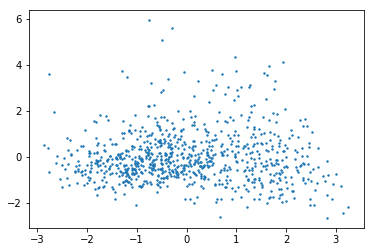

Component 1 (??): [-6.43111778e-01 -7.65769044e-01 -2.23765221e-03 -6.68484533e-05]
Component 2 (??): [-7.65765384e-01  6.43115519e-01 -2.31170501e-03 -6.80311277e-04]
Component 3 (??): [-3.21321441e-03 -2.24090811e-04  9.99969745e-01  7.08061195e-03]
Explained Variance: [716.07038935 125.73182588   3.89597288]


In [74]:
driver_features = {}
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    employed_days = 0
    ride_value = 0
    prime_time_rides = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            if ride_prime_time > 50:
                prime_time_rides += 1
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            employed_days = max(employed_days, ride_day+1)
            active_temp.add(ride_day)
            
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if total_rides > 0:
        # driver_features[driver_id] = [len(active_temp),employed_days,ride_value,prime_time_rides,total_rides]
        driver_features[driver_id] = [len(active_temp),employed_days,ride_value/total_rides,prime_time_rides/total_rides]

print(len(driver_ids))
print(len(driver_features))
X_clean = np.asarray([days for driver_id, days in driver_features.items()])
pca = PCA(n_components=3)
X_pca_clean = pca.fit_transform(X_clean)
plt.scatter(X_pca_clean[:,0],X_pca_clean[:,1],s=2)
plt.show()

print("Component 1 (??):", pca.components_[0])
print("Component 2 (??):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

# Normed
X_norm = np.asarray([days for driver_id, days in driver_features.items()])
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=3))])
X_pca_norm = pipeline.fit_transform(X_clean)
plt.scatter(X_pca_norm[:,0],X_pca_norm[:,1],s=2)
plt.show()

print("Component 1 (??):", pca.components_[0])
print("Component 2 (??):", pca.components_[1])
print("Component 3 (??):", pca.components_[2])
print("Explained Variance:", pca.explained_variance_)

### Summary Statistics

Average Rides per Active Day


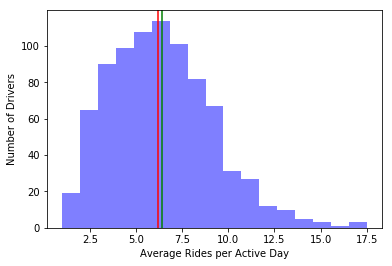

Average Ride Value Mean: 6.388399560355464 Average Ride Value Median: 6.2


In [200]:
#rides per day on active days
rides_per_day = []
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            active_temp.add(ride_day)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    #print(len(active_temp), total_rides)
    if(len(active_temp) > 0):
        rides_per_day.append(total_rides/(len(active_temp)+0.0))

average_ride_value_mean = np.mean(np.asarray(rides_per_day))
average_ride_value_median = np.median(np.asarray(rides_per_day))        
num_bins = 17
print("Average Rides per Active Day")
plt.xlabel('Average Rides per Active Day')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(rides_per_day, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

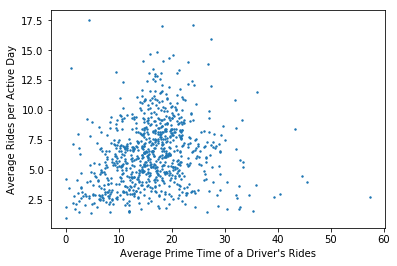

In [201]:
#rides per day on active days
rides_per_day = []
average_prime_time = []
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    total_rides = 0
    prime_time = 0
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            active_temp.add(ride_day)
            total_rides += 1
            prime_time += ride_ids_map[ride_id][2]
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    #print(len(active_temp), total_rides)
    if(len(active_temp) > 0 and total_rides > 0):
        rides_per_day.append(total_rides/(len(active_temp)+0.0))
        average_prime_time.append((prime_time+0.0)/total_rides)

plt.ylabel('Average Rides per Active Day')
plt.xlabel('Average Prime Time of a Driver\'s Rides')
plt.scatter(average_prime_time,rides_per_day,s=2)
plt.show()

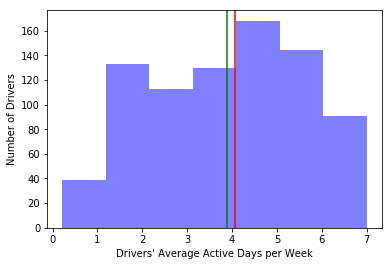

Average Ride Value Mean: 3.888407654987087 Average Ride Value Median: 4.0675675675675675


In [202]:
#weekday_counts[ride_timestamps_map[ride_id]['arrived_at'].weekday()] += 1
#average active days per week
hist_avg_active_days = []
for driver_id, onboard_date in driver_ids:
    active_day = set()
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            active_day.add(ride_day)
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    num_active = len(active_day)
    if(num_active > 0):
        last_day = max(active_day)
        if(last_day > 7):
            hist_avg_active_days.append(min(num_active/(last_day/7), 7))
            #print(num_active, (last_day/7)*7, last_day)
        
        
average_ride_value_mean = np.mean(np.asarray(hist_avg_active_days))
average_ride_value_median = np.median(np.asarray(hist_avg_active_days))        
num_bins = 7
plt.xlabel('Drivers\' Average Active Days per Week')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(hist_avg_active_days, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=average_ride_value_mean, color='green')
plt.axvline(x=average_ride_value_median, color='red')
plt.show()
print("Average Ride Value Mean:", average_ride_value_mean, "Average Ride Value Median:", average_ride_value_median)

## Driver Value

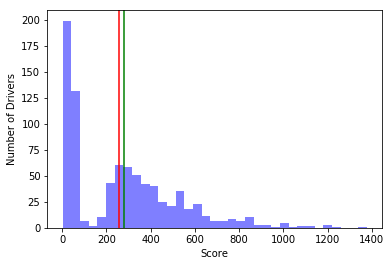

Score Mean: 3.888407654987087 Score Median: 4.0675675675675675


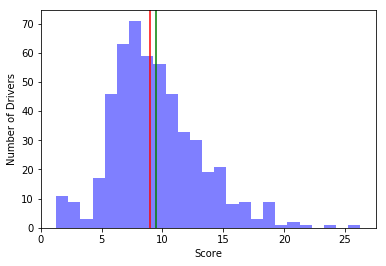

Score Mean: 3.888407654987087 Score Median: 4.0675675675675675


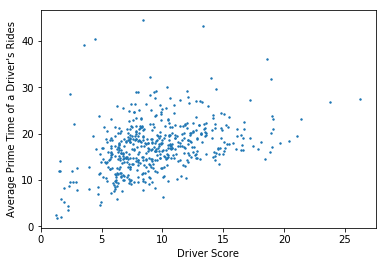

In [240]:
driver_score = {}
driver_score_per_day = {}
driver_num_days = {}
driver_prime_time = {}
for driver_id, onboard_date in driver_ids:
    active_temp = set()
    employed_days = 0
    ride_value = 0
    prime_time_rides = 0
    weekend_rides = 0
    total_rides = 0
    for ride_id in driver_to_ride.get(driver_id,[]):    
        try:
            ride_distance = ride_ids_map[ride_id][0]
            ride_duration = ride_ids_map[ride_id][1]
            ride_prime_time = ride_ids_map[ride_id][2]
            
            prime_time_rides += ride_prime_time
            ride_day = (ride_timestamps_map[ride_id]['arrived_at'] - onboard_date).days
            employed_days = max(employed_days, ride_day+1)
            active_temp.add(ride_day)
            
            if ride_timestamps_map[ride_id]['arrived_at'].weekday() >= 5:
                weekend_rides += 1
            
            ride_value += ride_cost(ride_distance,ride_duration,ride_prime_time)
            total_rides += 1
        except: # Note: This happens a lot...
            #print("Missing data... ride_id:",ride_id,"does not exist.")
            pass
    if total_rides > 0:
        time = (total_rides / len(active_temp)) * len(active_temp) * (1+len(active_temp) / employed_days)/2
        supply = 1 + (prime_time_rides / total_rides) / 50 + (weekend_rides / total_rides) / 2
        driver_score[driver_id] = time * supply
        driver_score_per_day[driver_id] = time * supply / len(active_temp)
        driver_num_days[driver_id] = len(active_temp)
        driver_prime_time[driver_id] = prime_time_rides / total_rides

scores = list(driver_score.values())
scores_mean = np.mean(np.asarray(scores))
scores_median = np.median(np.asarray(scores))        
num_bins = 35
plt.xlabel('Score')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=scores_mean, color='green')
plt.axvline(x=scores_median, color='red')
plt.show()
print("Score Mean:", average_ride_value_mean, "Score Median:", average_ride_value_median)

scores = np.asarray([x for driver_id, x in list(driver_score_per_day.items()) if driver_num_days[driver_id] > 20])
scores_mean = np.mean(scores)
scores_median = np.median(scores)        
num_bins = 25
plt.xlabel('Score')
plt.ylabel('Number of Drivers')
n, bins, patches = plt.hist(scores, num_bins, facecolor='blue', alpha=0.5)
plt.axvline(x=scores_mean, color='green')
plt.axvline(x=scores_median, color='red')
plt.show()
print("Score Mean:", average_ride_value_mean, "Score Median:", average_ride_value_median)

prime_time_scores = np.asarray([x for driver_id, x in list(driver_prime_time.items()) if driver_num_days[driver_id] > 20])
plt.ylabel('Average Prime Time of a Driver\'s Rides')
plt.xlabel('Driver Score')
plt.scatter(scores,prime_time_scores,s=2)
plt.show()